# Let's experimento

## Download the datasets

In [2]:
!git clone https://github.com/fosfrancesco/asap-dataset data/asap

fatal: destination path 'data/asap' already exists and is not an empty directory.


In [3]:
!wget -nc https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip -O data/eg-midi.zip
!unzip -n data/eg-midi.zip -d data/eg-midi

File ‘data/eg-midi.zip’ already there; not retrieving.
Archive:  data/eg-midi.zip


## Le imports

!pip3 install music21 partitura

In [244]:
import os
import pandas as pd
import partitura
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## What's inside? Pt. 1 - ASAP Dataset

In [6]:

ASAP_BASE_PATH = os.path.join('data', 'asap')
ASAP_METADATA_PATH = os.path.join(ASAP_BASE_PATH, 'metadata.csv')
asap_metadata_df = pd.read_csv(ASAP_METADATA_PATH)

In [7]:
asap_metadata_df.sample(10)

,composer,title,folder,xml_score,midi_score,midi_performance,performance_annotations,midi_score_annotations,maestro_midi_performance,maestro_audio_performance,start,end,audio_performance
559,Chopin,Etudes_op_10_4,Chopin/Etudes_op_10/4,Chopin/Etudes_op_10/4/xml_score.musicxml,Chopin/Etudes_op_10/4/midi_score.mid,Chopin/Etudes_op_10/4/BLINOV03.mid,Chopin/Etudes_op_10/4/BLINOV03_annotations.txt,Chopin/Etudes_op_10/4/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN
23,Bach,Fugue_bwv_858,Bach/Fugue/bwv_858,Bach/Fugue/bwv_858/xml_score.musicxml,Bach/Fugue/bwv_858/midi_score.mid,Bach/Fugue/bwv_858/Zhang01M.mid,Bach/Fugue/bwv_858/Zhang01M_annotations.txt,Bach/Fugue/bwv_858/midi_score_annotations.txt,{maestro}/2011/MIDI-Unprocessed_07_R1_2011_MID...,{maestro}/2011/MIDI-Unprocessed_07_R1_2011_MID...,90.330729,NaN,Bach/Fugue/bwv_858/Zhang01M.wav
679,Chopin,Etudes_op_25_8,Chopin/Etudes_op_25/8,Chopin/Etudes_op_25/8/xml_score.musicxml,Chopin/Etudes_op_25/8/midi_score.mid,Chopin/Etudes_op_25/8/Toscano02.mid,Chopin/Etudes_op_25/8/Toscano02_annotations.txt,Chopin/Etudes_op_25/8/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN
491,Chopin,Barcarolle,Chopin/Barcarolle,Chopin/Barcarolle/xml_score.musicxml,Chopin/Barcarolle/midi_score.mid,Chopin/Barcarolle/Na03.mid,Chopin/Barcarolle/Na03_annotations.txt,Chopin/Barcarolle/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN
618,Chopin,Etudes_op_10_8,Chopin/Etudes_op_10/8,Chopin/Etudes_op_10/8/xml_score.musicxml,Chopin/Etudes_op_10/8/midi_score.mid,Chopin/Etudes_op_10/8/Tetzloff07M.mid,Chopin/Etudes_op_10/8/Tetzloff07M_annotations.txt,Chopin/Etudes_op_10/8/midi_score_annotations.txt,{maestro}/2008/MIDI-Unprocessed_15_R1_2008_01-...,{maestro}/2008/MIDI-Unprocessed_15_R1_2008_01-...,NaN,NaN,Chopin/Etudes_op_10/8/Tetzloff07M.wav
951,Ravel,Miroirs_3_Une_Barque,Ravel/Miroirs/3_Une_Barque,Ravel/Miroirs/3_Une_Barque/xml_score.musicxml,Ravel/Miroirs/3_Une_Barque/midi_score.mid,Ravel/Miroirs/3_Une_Barque/ShevchenkoO07.mid,Ravel/Miroirs/3_Une_Barque/ShevchenkoO07_annot...,Ravel/Miroirs/3_Une_Barque/midi_score_annotati...,NaN,NaN,NaN,NaN,NaN
527,Chopin,Etudes_op_10_1,Chopin/Etudes_op_10/1,Chopin/Etudes_op_10/1/xml_score.musicxml,Chopin/Etudes_op_10/1/midi_score.mid,Chopin/Etudes_op_10/1/Zukiewicz02.mid,Chopin/Etudes_op_10/1/Zukiewicz02_annotations.txt,Chopin/Etudes_op_10/1/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN
922,Mozart,Piano_Sonatas_8-1,Mozart/Piano_Sonatas/8-1,Mozart/Piano_Sonatas/8-1/xml_score.musicxml,Mozart/Piano_Sonatas/8-1/midi_score.mid,Mozart/Piano_Sonatas/8-1/Jia01.mid,Mozart/Piano_Sonatas/8-1/Jia01_annotations.txt,Mozart/Piano_Sonatas/8-1/midi_score_annotation...,NaN,NaN,NaN,NaN,NaN
841,Liszt,Hungarian_Rhapsodies_6,Liszt/Hungarian_Rhapsodies/6,Liszt/Hungarian_Rhapsodies/6/xml_score.musicxml,Liszt/Hungarian_Rhapsodies/6/midi_score.mid,Liszt/Hungarian_Rhapsodies/6/KaiRuiR04.mid,Liszt/Hungarian_Rhapsodies/6/KaiRuiR04_annotat...,Liszt/Hungarian_Rhapsodies/6/midi_score_annota...,NaN,NaN,NaN,10.238542,NaN
512,Chopin,Etudes_op_10_1,Chopin/Etudes_op_10/1,Chopin/Etudes_op_10/1/xml_score.musicxml,Chopin/Etudes_op_10/1/midi_score.mid,Chopin/Etudes_op_10/1/Mikhailoff05.mid,Chopin/Etudes_op_10/1/Mikhailoff05_annotations...,Chopin/Etudes_op_10/1/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN


In [8]:
example_file = os.path.join(ASAP_BASE_PATH, asap_metadata_df.iloc[360]['midi_performance']) # Beethoven 30-1 CHEN2.mid
example_file

'data/asap/Beethoven/Piano_Sonatas/30-1/CHEN02.mid'

In [9]:
example_perf = partitura.load_performance_midi(example_file)
example_perf.performedparts

In [10]:
# we can see there is only one track, so we can access it directly
notes = example_perf.performedparts[0].note_array()
notes

array([(  2.0491433, 0.84401625,   1918,  249, 68, 36, 0, 0, 'n0'),
       (  2.2510662, 0.64209336,   2107,   81, 71, 44, 0, 0, 'n1'),
       (  2.4262795, 0.46687987,   2271,  187, 52, 35, 0, 0, 'n2'), ...,
       (236.07669  , 7.2841806 , 220968, 5538, 44, 24, 0, 0, 'n1515'),
       (236.08096  , 7.279907  , 220972, 6022, 40, 26, 0, 0, 'n1516'),
       (236.08951  , 7.2713604 , 220980, 5025, 52, 26, 0, 0, 'n1517')],
      dtype=[('onset_sec', '<f4'), ('duration_sec', '<f4'), ('onset_tick', '<i4'), ('duration_tick', '<i4'), ('pitch', '<i4'), ('velocity', '<i4'), ('track', '<i4'), ('channel', '<i4'), ('id', '<U256')])

So for each note we have:

* [0] = Triggered (second) (`float`)
* [1] = Duration (seconds) (`float`)
* [2] = Triggered (tick) (`int`)
* [3] = Duration (ticks) (`int`)
* [4] = Pitch (MIDI note number) (0-127) (`int`)
* [5] = Velocity (MIDI value) (0-127) (`int`)
* [6] = Track (`int`)
* [7] = MIDI Channel 0-15 (`int`)
* [8] = Note ID (`str`)

In [11]:
# let's create a helper enum and class for easier access to all those different properties
from enum import Enum

class Idx(Enum):
    ONSET_SECS = 0
    DURATION_SECS = 1
    ONSET_TICKS = 2
    DURATION_TICKS = 3
    PITCH = 4
    VELOCITY = 5
    TRACK = 6
    CHANNEL = 7
    ID = 8


class MidiNote:
    def __init__(self, notetuple):
        self.notetuple = notetuple

    @property
    def begin_secs(self):
        return self.notetuple[Idx.ONSET_SECS.value]

    @property
    def duration_secs(self):
        return self.notetuple[Idx.DURATION_SECS.value]

    @property
    def begin_ticks(self):
        return self.notetuple[Idx.ONSET_TICKS.value]

    @property
    def duration_ticks(self):
        return self.notetuple[Idx.DURATION_TICKS.value]

    @property
    def pitch(self):
        return self.notetuple[Idx.PITCH.value]

    @property
    def velocity(self):
        return self.notetuple[Idx.VELOCITY.value]

    @property
    def track(self):
        return self.notetuple[Idx.TRACK.value]

    @property
    def channel(self):
        return self.notetuple[Idx.CHANNEL.value]

    @property
    def id(self):
        return self.notetuple[Idx.ID.value]

    @property
    def end_secs(self):
        return self.begin_secs + self.duration_secs

    @property
    def end_ticks(self):
        return self.begin_ticks + self.duration_ticks

    def __repr__(self):
        return f'MidiNote({self.notetuple})'

*Note: MIDI velocity can only be in the range 0-127.*

## Creating a piano-roll representation

A piano-roll is a matrix where the rows are the notes and the columns are the time steps. 

We can extend it to add the velocity of the note as its value. Color-coding can be used to display the velocity.

That way we would get a nice 3D overview of the performance that shows the velocity of each note at each time step.

In [12]:
DRUM_MIDI_NAME = {
    35: 'Acoustic Bass Drum',
    36: 'Bass Drum 1',
    37: 'Side Stick',
    38: 'Acoustic Snare',
    39: 'Hand Clap',
    40: 'Electric Snare',
    41: 'Low Floor Tom',
    42: 'Closed Hi Hat',
    43: 'High Floor Tom',
    44: 'Pedal Hi-Hat',
    45: 'Low Tom',
    46: 'Open Hi-Hat',
    47: 'Low-Mid Tom',
    48: 'Hi-Mid Tom',
    49: 'Crash Cymbal 1',
    50: 'High Tom',
    51: 'Ride Cymbal 1',
    52: 'Chinese Cymbal',
    53: 'Ride Bell',
    54: 'Tambourine',
    55: 'Splash Cymbal',
    56: 'Cowbell',
    57: 'Crash Cymbal 2',
    58: 'Vibra Slap',
    59: 'Ride Cymbal 2',
    60: 'High Bongo',
    61: 'Low Bongo',
    62: 'Mute High Conga',
    63: 'Open High Conga',
    64: 'Low Conga',
    65: 'High Timbale',
    66: 'Low Timbale',
    67: 'High Agogo',
    68: 'Low Agogo',
    69: 'Cabasa',
    70: 'Maracas',
    71: 'Short Whistle',
    72: 'Long Whistle',
    73: 'Short Guiro',
    74: 'Long Guiro',
    75: 'Claves',
    76: 'High Wood Block',
    77: 'Low Wood Block',
    78: 'Mute Cuica',
    79: 'Open Cuica',
    80: 'Mute Triangle',
    81: 'Open Triangle'
}

In [13]:
TONES_FORMAT = [
    "C{octave}", 
    "C#{octave}/Db{octave}", 
    "D{octave}", 
    "D#{octave}/Eb{octave}", 
    "E{octave}", "F{octave}", 
    "F#{octave}/Gb{octave}", 
    "G{octave}", 
    "G#{octave}/Ab{octave}", 
    "A{octave}", 
    "A#{octave}/Bb{octave}", 
    "B{octave}",
]

def midi_number_to_tone(midi_number):
    """Converts a MIDI number to a tone name."""
    if midi_number < 0 or midi_number > 127:
        raise ValueError('MIDI number must be in [0, 127].')
    return TONES_FORMAT[midi_number % 12].format(octave=midi_number // 12 - 1)
    

In [14]:
def piano_roll(notes, is_drums=False):
    # get the time range of the piece
    # note: we will be working with ticks instead of seconds beacause they are integers
    start_tick = min(MidiNote(n).begin_ticks for n in notes)
    end_tick = max(MidiNote(n).end_ticks for n in notes)

    max_pitch = max(MidiNote(n).pitch for n in notes)
    min_pitch = min(MidiNote(n).pitch for n in notes)

    # init the piano-roll matrix with zeroes
    roll = np.zeros((max_pitch - min_pitch + 1, int(end_tick - start_tick)))  # shape is (pitches, ticks)

    # fill the matrix with the notes
    for n in notes:
        mn = MidiNote(n)
        pitch_idx = mn.pitch - min_pitch
        start_idx = int(mn.begin_ticks - start_tick)
        end_idx = int(mn.end_ticks - start_tick)
        velocity_normalized = mn.velocity / 127
        roll[pitch_idx, start_idx:end_idx] = velocity_normalized

    # plot the piano-roll
    plt.figure(figsize=(15, 12))
    plt.imshow(roll, aspect='auto', origin='lower', interpolation='none', cmap='Reds')
    plt.xlabel('time (MIDI ticks)')
    plt.ylabel('pitch' if not is_drums else 'drum kit piece')
    if is_drums:
        plt.yticks(
            range(roll.shape[0]), 
            [
                DRUM_MIDI_NAME.get(min_pitch + i, min_pitch + i)
                for i in range(roll.shape[0])
            ]
        )
    else:
        plt.yticks(
            range(roll.shape[0]),
            [
                midi_number_to_tone(min_pitch + i)
                for i in range(roll.shape[0])
            ]
        )
    plt.show()

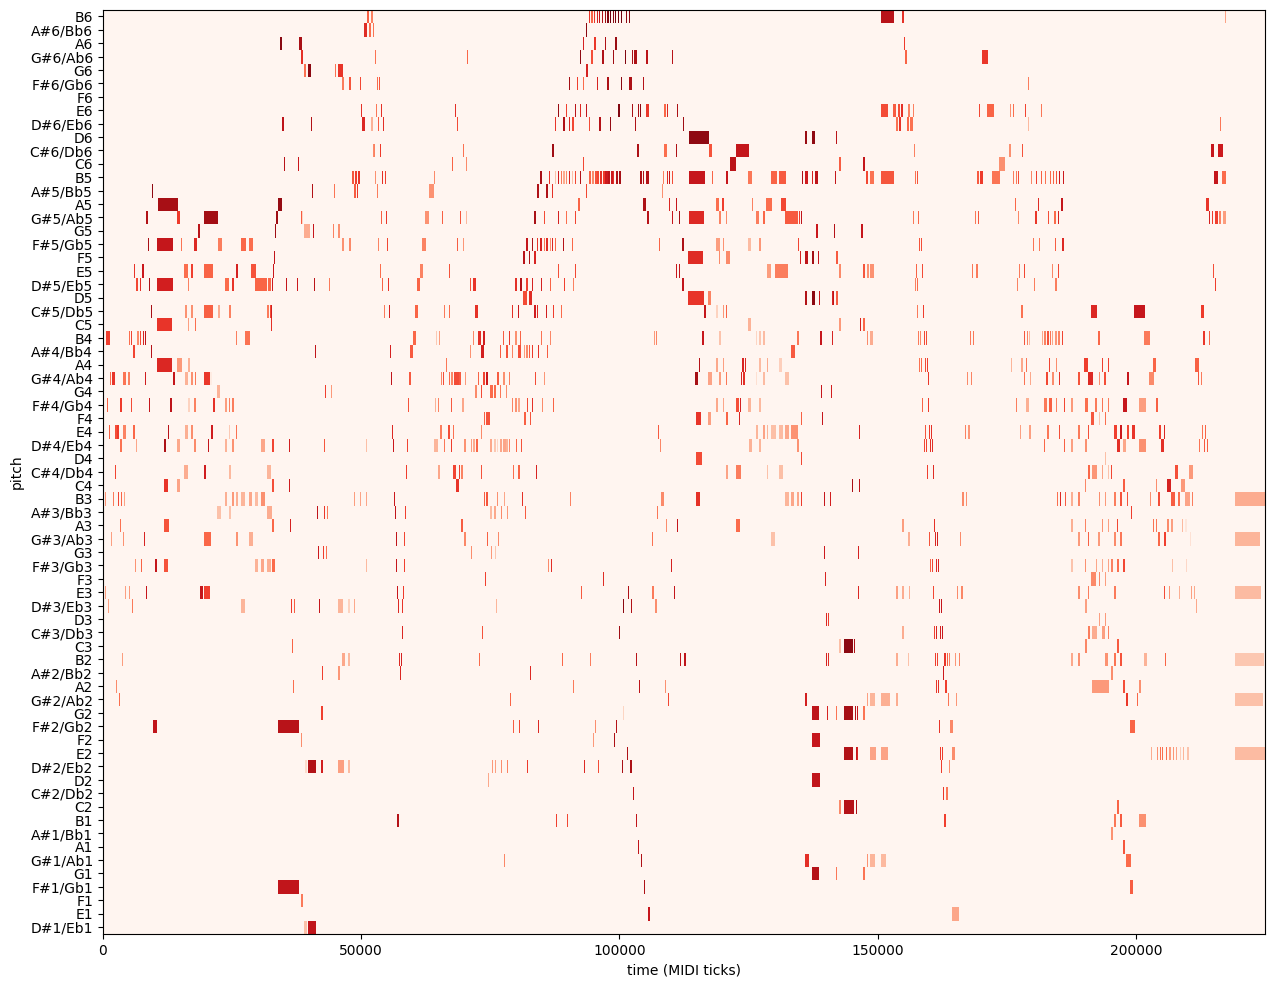

In [15]:
piano_roll(notes)

## MIDI playback in the notebook

In [16]:
!brew install fluidsynth || apt-get install fluidsynth

==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
To reinstall 2.3.4, run:
  brew reinstall fluid-synth


In [17]:
!pip3 install pyfluidsynth


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


A soundfont needs to be downloaded (that has at least a piano). I will use a General MIDI one: FluidR3_GM.sf2.

In [18]:
!wget -nc https://keymusician01.s3.amazonaws.com/FluidR3_GM.zip -O sf/big/FluidR3_GM.zip
!unzip -n sf/big/FluidR3_GM.zip -d sf/big/FluidR3_GM

File ‘sf/big/FluidR3_GM.zip’ already there; not retrieving.
Archive:  sf/big/FluidR3_GM.zip


In [19]:
SF_PATH = os.path.join('sf', 'big', 'FluidR3_GM', 'FluidR3_GM.sf2')

In [20]:
import fluidsynth
from IPython.display import Audio

def play_midi_file(path, is_drums=False, sr=44100):
    """Play the first track of a MIDI file in the Jupyter notebook."""
    m = partitura.load_performance_midi(path)
    notes = m.performedparts[0].note_array()
    return play_midi_notes(notes, is_drums=is_drums, sr=sr) 


def play_midi_notes(notes: np.ndarray, is_drums=False, sr=44100):
    # Set up MIDI player
    fl = fluidsynth.Synth(samplerate=sr)
    sfid = fl.sfload(SF_PATH)
    channel = 9 if is_drums else 0
    bank = 128 if is_drums else 0
    preset = 0
    fl.program_select(channel, sfid, bank, preset)

    # Get a timeline of all note on and note off events
    # and sort it so that it can be iterated in order
    events: dict[float, tuple[str, MidiNote]] = {}
    events.update({MidiNote(n).begin_secs : ("on", MidiNote(n)) for n in notes})
    events.update({MidiNote(n).end_secs : ("off", MidiNote(n)) for n in notes})
    sorted_events_keys = sorted(events.keys())
    
    # Render the MIDI note events as audio
    audio_data = []
    for curr_time, next_time in zip(sorted_events_keys[:-1], sorted_events_keys[1:]):
        event_type = events[curr_time][0]
        note = events[curr_time][1]

        if event_type == "on":
            fl.noteon(note.channel, note.pitch, note.velocity)
        elif event_type == "off":
            fl.noteoff(note.channel, note.pitch)
        
        time_interval = next_time - curr_time
        interval_samples = fl.get_samples(int(time_interval * sr))
        audio_data.extend(interval_samples[::2]) # cut off one of the stereo channels
        # because I could not find how to set the Synth to play mono

    # Normalize audio data and play it in the notebook
    audio_data = np.array(audio_data, dtype="int16")
    audio_data = audio_data / (2**15 - 1)
    return Audio(audio_data, rate=sr)

In [ ]:
play_midi_file(example_file)

## What's inside? Pt 2 - Expanded Groove MIDI dataset

https://magenta.tensorflow.org/datasets/e-gmd

In [22]:
EGMIDI_BASE_PATH = os.path.join('data', 'eg-midi', 'e-gmd-v1.0.0')
EGMIDI_METADATA_PATH = os.path.join(EGMIDI_BASE_PATH, 'e-gmd-v1.0.0.csv')
egmidi_metadata_df = pd.read_csv(EGMIDI_METADATA_PATH)

In [23]:
egmidi_metadata_df.sample(10)

,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
19290,drummer1,drummer1/session2,drummer1/session2/55,punk,128,fill,4-4,1.755011,train,drummer1/session2/55_punk_128_fill_4-4_37.midi,drummer1/session2/55_punk_128_fill_4-4_37.wav,Live Fusion
38585,drummer8,drummer8/session1,drummer8/session1/14,hiphop,94,beat,4-4,163.144830,train,drummer8/session1/14_hiphop_94_beat_4-4_23.midi,drummer8/session1/14_hiphop_94_beat_4-4_23.wav,Second Line
24631,drummer3,drummer3/session2,drummer3/session2/34,rock,92,beat,4-4,9.475193,train,drummer3/session2/34_rock_92_beat_4-4_53.midi,drummer3/session2/34_rock_92_beat_4-4_53.wav,Unplugged
23801,drummer3,drummer3/session2,drummer3/session2/15,rock,100,beat,4-4,14.284014,train,drummer3/session2/15_rock_100_beat_4-4_33.midi,drummer3/session2/15_rock_100_beat_4-4_33.wav,Shuffle (Blues)
8222,drummer1,drummer1/session1,drummer1/session1/175,latin/brazilian-baiao,95,fill,4-4,2.526304,train,drummer1/session1/175_latin-brazilian-baiao_95...,drummer1/session1/175_latin-brazilian-baiao_95...,Big Room (Layered)
31803,drummer7,drummer7/session2,drummer7/session2/6,rock,120,beat,4-4,44.312381,train,drummer7/session2/6_rock_120_beat_4-4_37.midi,drummer7/session2/6_rock_120_beat_4-4_37.wav,Live Fusion
39031,drummer8,drummer8/session1,drummer8/session1/26,afrobeat,94,beat,4-4,195.723900,train,drummer8/session1/26_afrobeat_94_beat_4-4_43.midi,drummer8/session1/26_afrobeat_94_beat_4-4_43.wav,Funk Rock
16978,drummer1,drummer1/session2,drummer1/session2/17,country,114,fill,4-4,2.021587,train,drummer1/session2/17_country_114_fill_4-4_54.midi,drummer1/session2/17_country_114_fill_4-4_54.wav,Nu RNB
36316,drummer7,drummer7/session3,drummer7/session3/40,rock/indie,63,fill,4-4,1.966735,train,drummer7/session3/40_rock-indie_63_fill_4-4_35...,drummer7/session3/40_rock-indie_63_fill_4-4_35...,Rockin Gate (80s)
2581,drummer5,drummer5/eval_session,drummer5/eval_session/5,funk/groove5,84,beat,4-4,45.714286,test,drummer5/eval_session/5_funk-groove5_84_beat_4...,drummer5/eval_session/5_funk-groove5_84_beat_4...,JingleStacks (2nd Hi-Hat)


In [24]:
example_drums_midi = os.path.join(EGMIDI_BASE_PATH, egmidi_metadata_df.iloc[0]['midi_filename'])
example_drums_midi

'data/eg-midi/e-gmd-v1.0.0/drummer1/eval_session/1_funk-groove1_138_beat_4-4_1.midi'

In [25]:
example_drums_midi_perf = partitura.load_performance_midi(example_drums_midi)
example_drums_midi_perf.performedparts

In [26]:
example_drum_notes = example_drums_midi_perf.performedparts[0].note_array()
example_drum_notes

array([(2.71739368e-03, 0.10144937,     3, 112, 55,  60, 0, 9, 'n0'),
       (6.34058565e-03, 0.10054357,     7, 111, 51,  55, 0, 9, 'n1'),
       (9.05797910e-03, 0.09963777,    10, 110, 36,  64, 0, 9, 'n2'),
       (1.91123366e-01, 0.10054357,   211, 111, 36,  57, 0, 9, 'n3'),
       (2.15579897e-01, 0.09963777,   238, 110, 51,  31, 0, 9, 'n4'),
       (4.03985858e-01, 0.10144937,   446, 112, 44,  77, 0, 9, 'n5'),
       (4.23007637e-01, 0.10054357,   467, 111, 51,  54, 0, 9, 'n6'),
       (4.30254012e-01, 0.10054357,   475, 111, 38,  93, 0, 9, 'n7'),
       (6.03261411e-01, 0.10235517,   666, 113, 44,  52, 0, 9, 'n8'),
       (6.37681723e-01, 0.10144937,   704, 112, 51,  42, 0, 9, 'n9'),
       (7.50000656e-01, 0.10054357,   828, 111, 38,  33, 0, 9, 'n10'),
       (8.22464526e-01, 0.05706527,   908,  63, 44,  77, 0, 9, 'n11'),
       (8.51450026e-01, 0.02807974,   940,  31, 51,  46, 0, 9, 'n12'),
       (9.65580583e-01, 0.10054357,  1066, 111, 38,  33, 0, 9, 'n13'),
       (1.024457

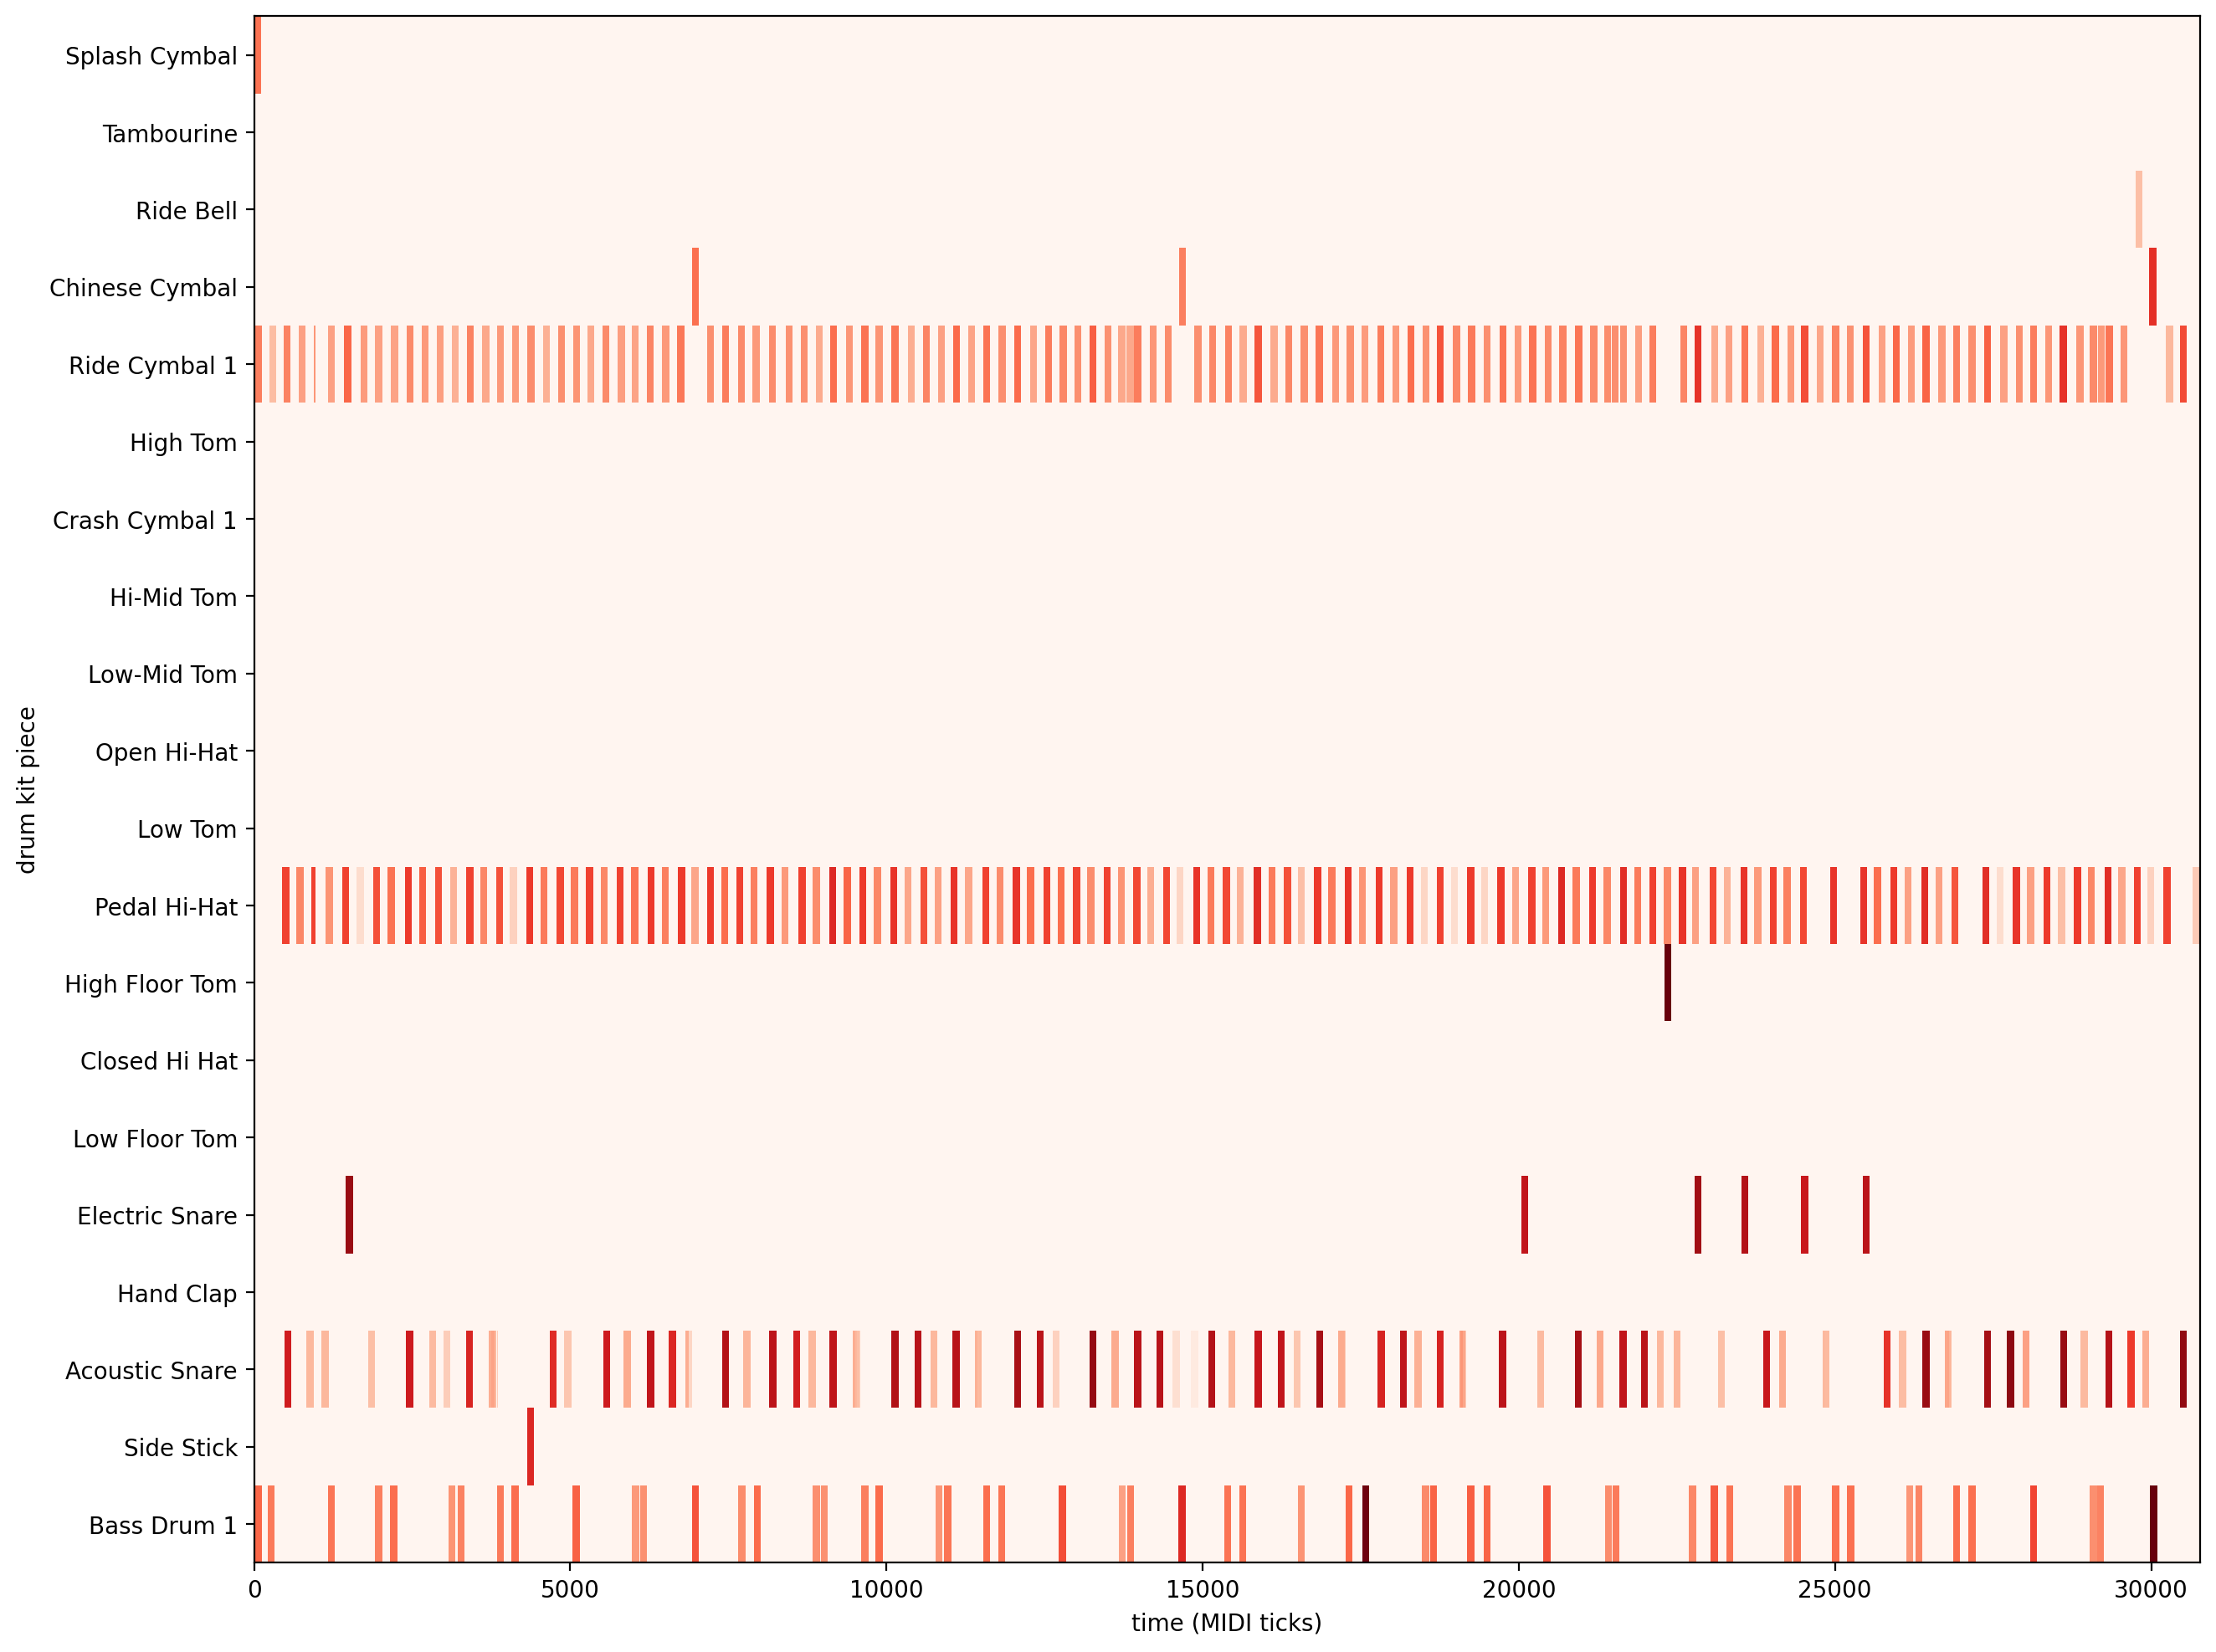

In [27]:
piano_roll(example_drum_notes, is_drums=True)

In [ ]:
play_midi_file(example_drums_midi, is_drums=True)

## Drums experiments

### Preparing drums data

We are only interested in whole grooves, so let's filter out the ones that are not.
Also retain only filename, genre, tempo and split information.

In [34]:
drums_metadata_df = egmidi_metadata_df[egmidi_metadata_df['beat_type'] == 'beat'][["midi_filename", "time_signature", "style", "bpm", "split"]]
drums_metadata_df.sample(10)

,midi_filename,time_signature,style,bpm,split
42671,drummer1/session2/62_punk_144_beat_4-4_24.midi,4-4,punk,144,validation
23327,drummer3/session1/48_rock_120_beat_4-4_32.midi,4-4,rock,120,train
21083,drummer1/session3/16_funk_117_beat_4-4_22.midi,4-4,funk,117,train
23568,drummer3/session1/9_rock_105_beat_4-4_13.midi,4-4,rock,105,train
42997,drummer1/session3/15_funk_117_beat_4-4_58.midi,4-4,funk,117,validation
39295,drummer8/session1/6_funk_80_beat_4-4_54.midi,4-4,funk,80,train
23433,drummer3/session1/5_rock_105_beat_4-4_6.midi,4-4,rock,105,train
5026,drummer8/eval_session/8_rock-groove8_65_beat_4-4_56.midi,4-4,rock/groove8,65,test
27765,drummer7/session1/1_rock_86_beat_4-4_43.midi,4-4,rock,86,train
5149,drummer8/session1/8_funk_96_beat_4-4_5.midi,4-4,funk,96,test


In [36]:
drums_train_df = drums_metadata_df[drums_metadata_df['split'] == 'train']
drums_valid_df = drums_metadata_df[drums_metadata_df['split'] == 'validation']
drums_test_df = drums_metadata_df[drums_metadata_df['split'] == 'test']

drums_train_df.shape, drums_valid_df.shape, drums_test_df.shape

((13588, 5), (1892, 5), (3096, 5))

In [37]:

def append_drum_midi_features(df: pd.DataFrame):
    features_df = pd.DataFrame(columns=['notes_array', 'velocities_array'])
    i = 0
    for filename, time_signature, style, bpm, split in df.values:
        i += 1
        if i % 1000 == 0:
            print(f"{i//1000}K", end="")
        elif i % 100 == 0:
            print(".", end="")
        filepath = os.path.join(EGMIDI_BASE_PATH, filename)
        midi = partitura.load_performance_midi(filepath)
        notes = midi.performedparts[0].note_array()
        velocities = [t[Idx.VELOCITY.value] for t in notes]
        features_df.loc[len(features_df)] = [notes, velocities]
    df = pd.concat([df.reset_index(drop=True), features_df], axis=1)
    return df



In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # ignoring warnings for MIDI msg with velocity=0
    print("Train df:")
    drums_train_midi_df = append_drum_midi_features(drums_train_df)
    print("\nValid df:")
    drums_valid_midi_df = append_drum_midi_features(drums_valid_df)
    print("\nTest df:")
    drums_test_midi_df = append_drum_midi_features(drums_test_df)

Train df:
.........1K.........2K.........3K.........4K.........5K.........6K.........7K.........8K.........9K.........10K.........11K.........12K.........13K.....
Valid df:
.........1K........
Test df:
.........1K.........2K.........3K

In [39]:
drums_train_midi_df.sample(3)

,midi_filename,time_signature,style,bpm,split,notes_array,velocities_array
5892,drummer3/session2/43_rock_110_beat_4-4_10.midi,4-4,rock,110,train,"[[0.338636, 0.10227262, 298, 90, 42, 23, 0, 9, n0], [0.5272722, 0.0999999, 464, 88, 38, 127, 0, 9, n1], [0.52954495, 0.10113626, 466, 89, 42, 127, 0, 9, n2], [0.87613547, 0.10113626, 771, 89, 42, 41, 0, 9, n3], [1.0772717, 0.10113626, 948, 89, 42, 127, 0, 9, n4], [1.442044, 0.10113626, 1269, 89, 42, 16, 0, 9, n5], [1.6386347, 0.10113626, 1442, 89, 38, 127, 0, 9, n6], [1.6409074, 0.10113626, 1444, 89, 42, 127, 0, 9, n7], [1.9795434, 0.10113626, 1742, 89, 42, 22, 0, 9, n8], [2.1488614, 0.10227262, 1891, 90, 42, 127, 0, 9, n9], [2.5409067, 0.10113626, 2236, 89, 42, 46, 0, 9, n10], [2.7340882,...","[23, 127, 127, 41, 127, 16, 127, 127, 22, 127, 46, 127, 127, 67, 92, 127, 127, 127, 122, 127, 40, 127, 127, 44, 127, 127, 35, 127, 127, 119, 127, 48, 127, 127, 69, 82, 127, 101, 127, 127, 125, 127, 45, 127, 127, 52, 127, 127, 57, 112, 127, 56, 127, 127, 50, 106, 127, 84, 101, 127, 127, 127, 127, 127, 127, 127, 127, 48, 127, 114, 57, 127, 127, 103, 94, 127, 127, 43, 124, 127, 53, 105, 127, 127, 127, 127, 127, 127, 107, 127, 127, 66, 62, 127, 127, 46, 127, 127, 62, 125, ...]"
10818,drummer7/session3/129_rock_93_beat_4-4_36.midi,4-4,rock,93,train,"[[0.0067204167, 0.10080625, 5, 75, 36, 52, 0, 9, n0], [0.025537584, 0.09946217, 19, 74, 53, 127, 0, 9, n1], [0.16666633, 0.102150336, 124, 76, 22, 31, 0, 9, n2], [0.3239241, 0.10080625, 241, 75, 51, 11, 0, 9, n3], [0.48924634, 0.10080625, 364, 75, 22, 127, 0, 9, n4], [0.6666653, 0.10080625, 496, 75, 51, 77, 0, 9, n5], [0.81989086, 0.102150336, 610, 76, 42, 29, 0, 9, n6], [0.9583314, 0.10080625, 713, 75, 36, 55, 0, 9, n7], [0.98924536, 0.10080625, 736, 75, 51, 25, 0, 9, n8], [1.1384386, 0.10080625, 847, 75, 42, 21, 0, 9, n9], [1.3024168, 0.10080625, 969, 75, 53, 79, 0, 9, n10], [1.4596745, ...","[52, 127, 31, 11, 127, 77, 29, 55, 25, 21, 79, 91, 42, 43, 105, 118, 21, 42, 64, 59, 54, 16, 13, 52, 16, 127, 55, 36, 39, 60, 40, 36, 98, 86, 28, 37, 105, 108, 38, 36, 41, 59, 86, 44, 26, 127, 47, 87, 41, 27, 56, 36, 104, 74, 32, 28, 108, 96, 33, 36, 69, 55, 17, 70, 16, 59, 51, 49, 127, 53, 49, 123, 95, 122, 127, 48, 67, 65, 93, 127, 120, 92, 60, 20, 127, 60, 35, 37, 33, 127, 45, 44, 30, 43, 57, 40, 125, 105, 45, 45, ...]"
9550,drummer7/session2/29_rock_75_beat_4-4_13.midi,4-4,rock,75,train,"[[0.35333332, 0.10166667, 212, 61, 38, 109, 0, 9, n0], [0.39, 0.1, 234, 60, 40, 119, 0, 9, n1], [0.745, 0.1, 447, 60, 37, 87, 0, 9, n2], [0.76166666, 0.1, 457, 60, 40, 127, 0, 9, n3], [0.93833333, 0.1, 563, 60, 38, 35, 0, 9, n4], [1.14, 0.1, 684, 60, 48, 127, 0, 9, n5], [1.3416667, 0.1, 805, 60, 38, 40, 0, 9, n6], [1.5366666, 0.10166667, 922, 61, 38, 61, 0, 9, n7], [1.7516667, 0.1, 1051, 60, 48, 127, 0, 9, n8], [1.95, 0.10166667, 1170, 61, 37, 56, 0, 9, n9], [2.16, 0.1, 1296, 60, 38, 127, 0, 9, n10], [2.3616667, 0.10166667, 1417, 61, 45, 127, 0, 9, n11], [2.56, 0.1, 1536, 60, 43, 66, 0, 9,...","[109, 119, 87, 127, 35, 127, 40, 61, 127, 56, 127, 127, 66, 102, 40, 96, 109, 96, 127, 36, 43, 37, 25, 54, 86, 52, 13, 51, 42, 103, 105, 33, 36, 84, 46, 42, 44, 34, 127, 110, 35, 50, 49, 36, 87, 53, 38, 33, 31, 85, 111, 29, 81, 60, 77, 53, 35, 11, 36, 18, 89, 112, 34, 37, 24, 35, 55, 83, 31, 5, 20, 19, 81, 114, 23, 21, 27, 6, 27, 36, 49, 75, 25, 7, 35, 27, 86, 120, 31, 27, 10, 73, 80, 19, 6, 30, 42, 41, 84, 115, ...]"


In [215]:
def sequence_lengths(df: pd.DataFrame):
    return [len(notes) for notes in df['notes_array']]

In [217]:
def extract_drum_tensor_features(df_row: pd.Series) -> tuple[torch.Tensor]:
    """Return a tensor containing features to feed the NN with. Data is normalized [0-1]."""
    max_secs = max(t[Idx.ONSET_SECS.value] + t[Idx.DURATION_SECS.value] for t in df_row['notes_array'])
    max_duration = max(t[Idx.DURATION_SECS.value] for t in df_row['notes_array'])

    features = torch.Tensor([
        [
            t[Idx.ONSET_SECS.value] / max_secs,  # TODO: use dt instead of absolute time?
            t[Idx.DURATION_SECS.value] / max_duration,
            t[Idx.PITCH.value] / 127,  # TODO: for drums, more appropriate would be one-hot encoding?
            # TODO: add more features, e.g. how to encode genre? embeddings?
        ]
        for t in df_row['notes_array']
    ])
    
    return features

In [218]:
drums_train_lengths = sequence_lengths(drums_train_midi_df)
drums_valid_lengths = sequence_lengths(drums_valid_midi_df)
drums_test_lengths = sequence_lengths(drums_test_midi_df)

max(drums_train_lengths), max(drums_valid_lengths), max(drums_test_lengths)

(7428, 2821, 3236)

In [220]:
def get_drums_X_y(df: pd.DataFrame) -> tuple[torch.Tensor, torch.Tensor]:
    X = [
        extract_drum_tensor_features(row)
        for _, row in df.iterrows()
    ]
    y = [
        torch.Tensor(row['velocities_array']) / 127
        for _, row in df.iterrows()
    ]

    X = nn.utils.rnn.pad_sequence(X, batch_first=True)
    y = nn.utils.rnn.pad_sequence(y, batch_first=True)[..., None]

    return X, y


In [221]:
X_drums_train, y_drums_train = get_drums_X_y(drums_train_midi_df)
X_drums_valid, y_drums_valid = get_drums_X_y(drums_valid_midi_df)
X_drums_test, y_drums_test = get_drums_X_y(drums_test_midi_df)

X_drums_train.shape, y_drums_train.shape, X_drums_valid.shape, y_drums_valid.shape, X_drums_test.shape, y_drums_test.shape

(torch.Size([13588, 7428, 3]),
 torch.Size([13588, 7428, 1]),
 torch.Size([1892, 2821, 3]),
 torch.Size([1892, 2821, 1]),
 torch.Size([3096, 3236, 3]),
 torch.Size([3096, 3236, 1]))

In [83]:
drums_train_lengths = torch.LongTensor(drums_train_lengths)
drums_valid_lengths = torch.LongTensor(drums_valid_lengths)
drums_test_lengths = torch.LongTensor(drums_test_lengths)

drums_train_lengths.shape, drums_valid_lengths.shape, drums_test_lengths.shape

(torch.Size([13588]), torch.Size([1892]), torch.Size([3096]))

In [84]:

drums_train_ds = TensorDataset(X_drums_train, drums_train_lengths, y_drums_train)
drums_valid_ds = TensorDataset(X_drums_valid, drums_valid_lengths, y_drums_valid)
drums_test_ds = TensorDataset(X_drums_test, drums_test_lengths, y_drums_test)

In [85]:
drums_train_dataloader = DataLoader(drums_train_ds, batch_size=64)
drums_valid_dataloader = DataLoader(drums_valid_ds, batch_size=64)

### Learning how to drum

In [98]:
class DrumsLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, x, seq_lengths):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(packed_x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        return x

In [99]:
drums_model = DrumsLSTM(input_size=X_drums_train.shape[-1], hidden_size=1, num_layers=1)

In [102]:
NUM_EPOCHS = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(drums_model.parameters(), lr=0.01)

def compute_loss(y_pred, y_true, seq_lengths):
    losses = [
        criterion(y_pred[batch_row, :seq_len, :], y_true[batch_row, :seq_len, :])
        for batch_row, seq_len in enumerate(seq_lengths)
    ]
    return torch.mean(torch.stack(losses))


for epoch in range(NUM_EPOCHS):
    print(f"=== Epoch {epoch+1} / {NUM_EPOCHS} ===")

    drums_model.train()  # training
    for i, (X, seq_lengths, y) in enumerate(drums_train_dataloader):
        y_pred = drums_model(X, seq_lengths)

        loss = compute_loss(y_pred, y, seq_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"[T] Batch {i} / {len(drums_train_dataloader)-1} loss: {loss.item():.4f}")

    drums_model.eval()  # validation
    with torch.no_grad():
        validation_losses = []
        for i, (X, seq_lengths, y) in enumerate(drums_valid_dataloader):
            y_pred = drums_model(X, seq_lengths)
            validation_losses.append(compute_loss(y_pred, y, seq_lengths))
        print(f"[V] Validation mean loss: {torch.mean(torch.stack(validation_losses)).item():.4f}")
    

=== Epoch 1 / 10 ===
[T] Batch 0 / 212 loss: 0.1777
[T] Batch 50 / 212 loss: 0.1662
[T] Batch 100 / 212 loss: 0.1263
[T] Batch 150 / 212 loss: 0.1294
[T] Batch 200 / 212 loss: 0.0606
[V] Validation mean loss: 0.0925
=== Epoch 2 / 10 ===
[T] Batch 0 / 212 loss: 0.1074
[T] Batch 50 / 212 loss: 0.0651
[T] Batch 100 / 212 loss: 0.1164
[T] Batch 150 / 212 loss: 0.1250
[T] Batch 200 / 212 loss: 0.0590
[V] Validation mean loss: 0.0904
=== Epoch 3 / 10 ===
[T] Batch 0 / 212 loss: 0.1069
[T] Batch 50 / 212 loss: 0.0603
[T] Batch 100 / 212 loss: 0.1111
[T] Batch 150 / 212 loss: 0.1228
[T] Batch 200 / 212 loss: 0.0583
[V] Validation mean loss: 0.0888
=== Epoch 4 / 10 ===
[T] Batch 0 / 212 loss: 0.1061
[T] Batch 50 / 212 loss: 0.0583
[T] Batch 100 / 212 loss: 0.1075
[T] Batch 150 / 212 loss: 0.1215
[T] Batch 200 / 212 loss: 0.0578
[V] Validation mean loss: 0.0877
=== Epoch 5 / 10 ===
[T] Batch 0 / 212 loss: 0.1054
[T] Batch 50 / 212 loss: 0.0574
[T] Batch 100 / 212 loss: 0.1049
[T] Batch 150 / 212

In [109]:
# Test dataset loss
compute_loss(drums_model(X_drums_test, drums_test_lengths), y_drums_test, drums_test_lengths).item()

0.07966231554746628

In [222]:
# Baseline loss
baseline_velocity = torch.Tensor([100 / 127])  # velocity of 100 seems pretty average
y_baseline = baseline_velocity.repeat(*y_drums_test.shape)

compute_loss(y_baseline, y_drums_test, drums_test_lengths).item()

NameError: name 'y_drums_test' is not defined

### Let's hear it play!

Get a random sample

In [192]:
drums_sample = drums_test_midi_df.sample(1)
drums_sample_file_notes = drums_sample.iloc[0]["notes_array"]

Inspect and hear the original

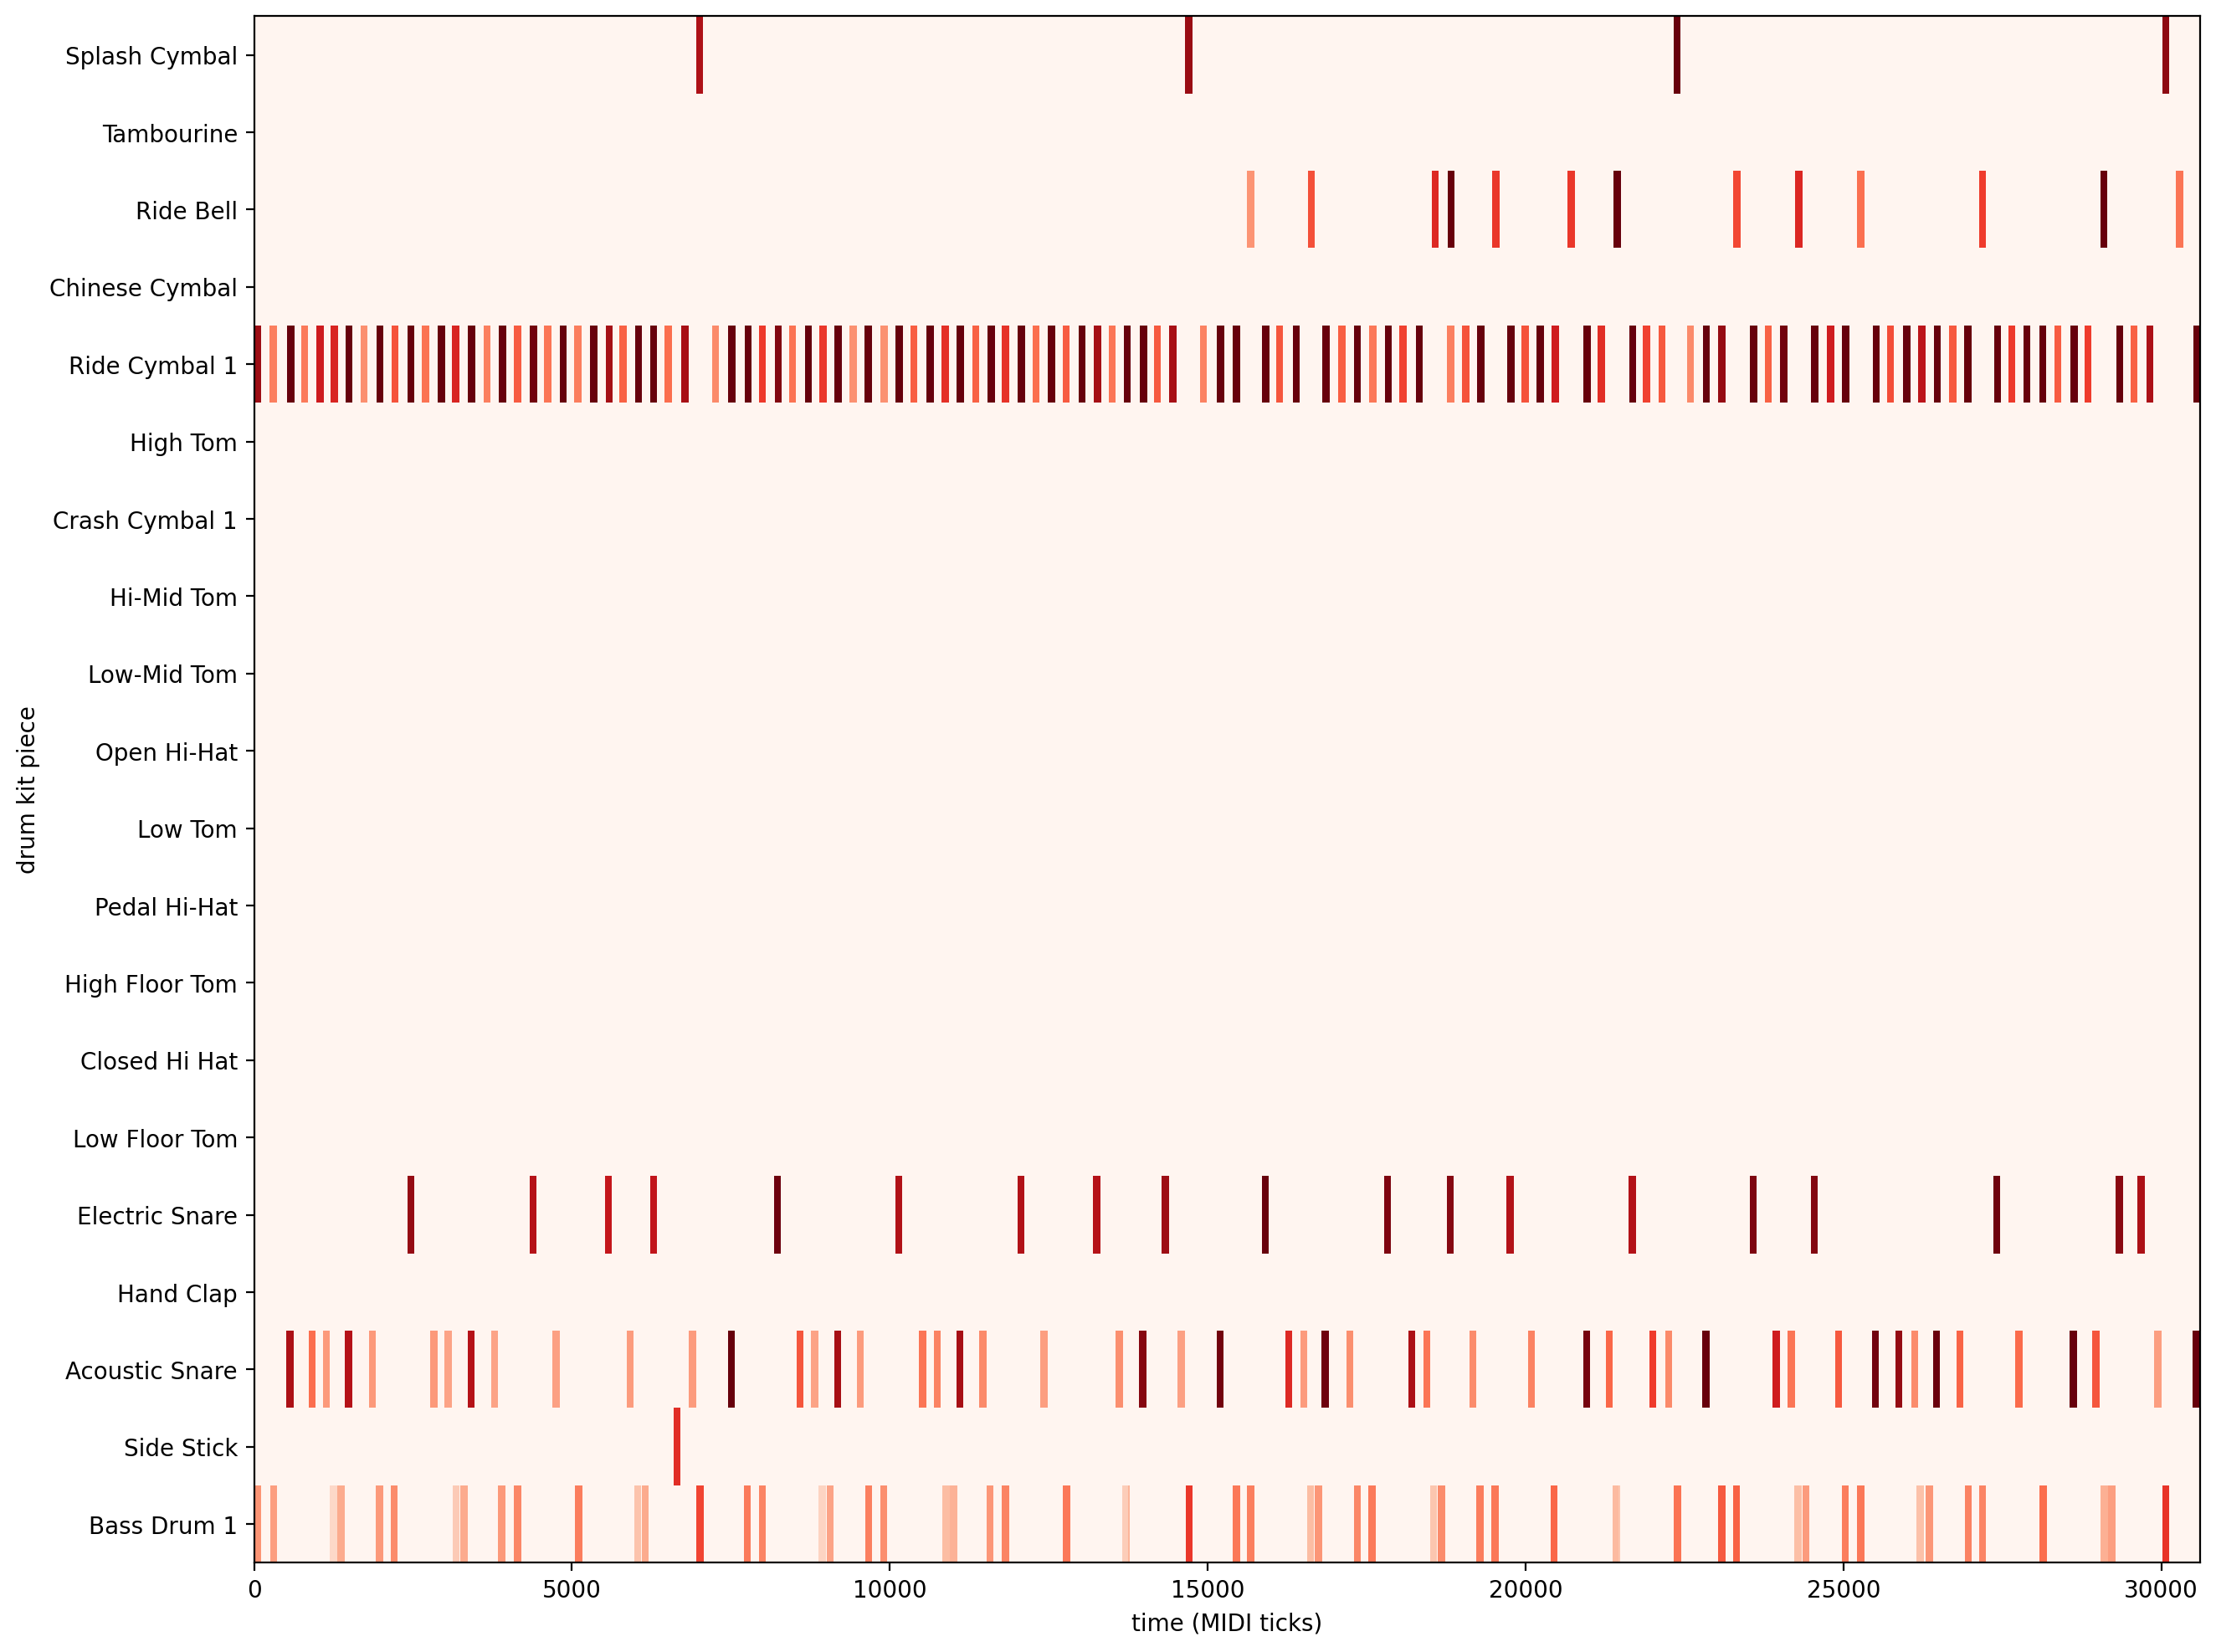

In [202]:
piano_roll(drums_sample_file_notes, is_drums=True)

In [ ]:
play_midi_notes(drums_sample_file_notes, is_drums=True)

Run the model for the sample

In [204]:
X, y = get_drums_X_y(drums_sample)
seq_len = torch.LongTensor([len(drums_sample_file_notes)])

X.shape, y.shape, seq_len

(torch.Size([1, 257, 3]), torch.Size([1, 257, 1]), tensor([257]))

Compute the loss for debugging purposes

In [205]:
y_pred = drums_model(X, seq_len)
velocities_pred = (y_pred[0, :seq_len[0], :].detach().numpy() * 127).astype(int)
notes_pred = drums_sample_file_notes.copy()
for i, velocity in enumerate(velocities_pred):
    notes_pred[i][Idx.VELOCITY.value] = velocity

mean_squared_error(
    [n[Idx.VELOCITY.value] for n in drums_sample_file_notes], 
    [n[Idx.VELOCITY.value] for n in notes_pred],
    squared=False
)

/var/folders/c1/wnpj64n160b5_hpc84y3ry340000gq/T/ipykernel_32445/3416690591.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  notes_pred[i][Idx.VELOCITY.value] = velocity


33.400470650706644

Inspect and hear the model's output

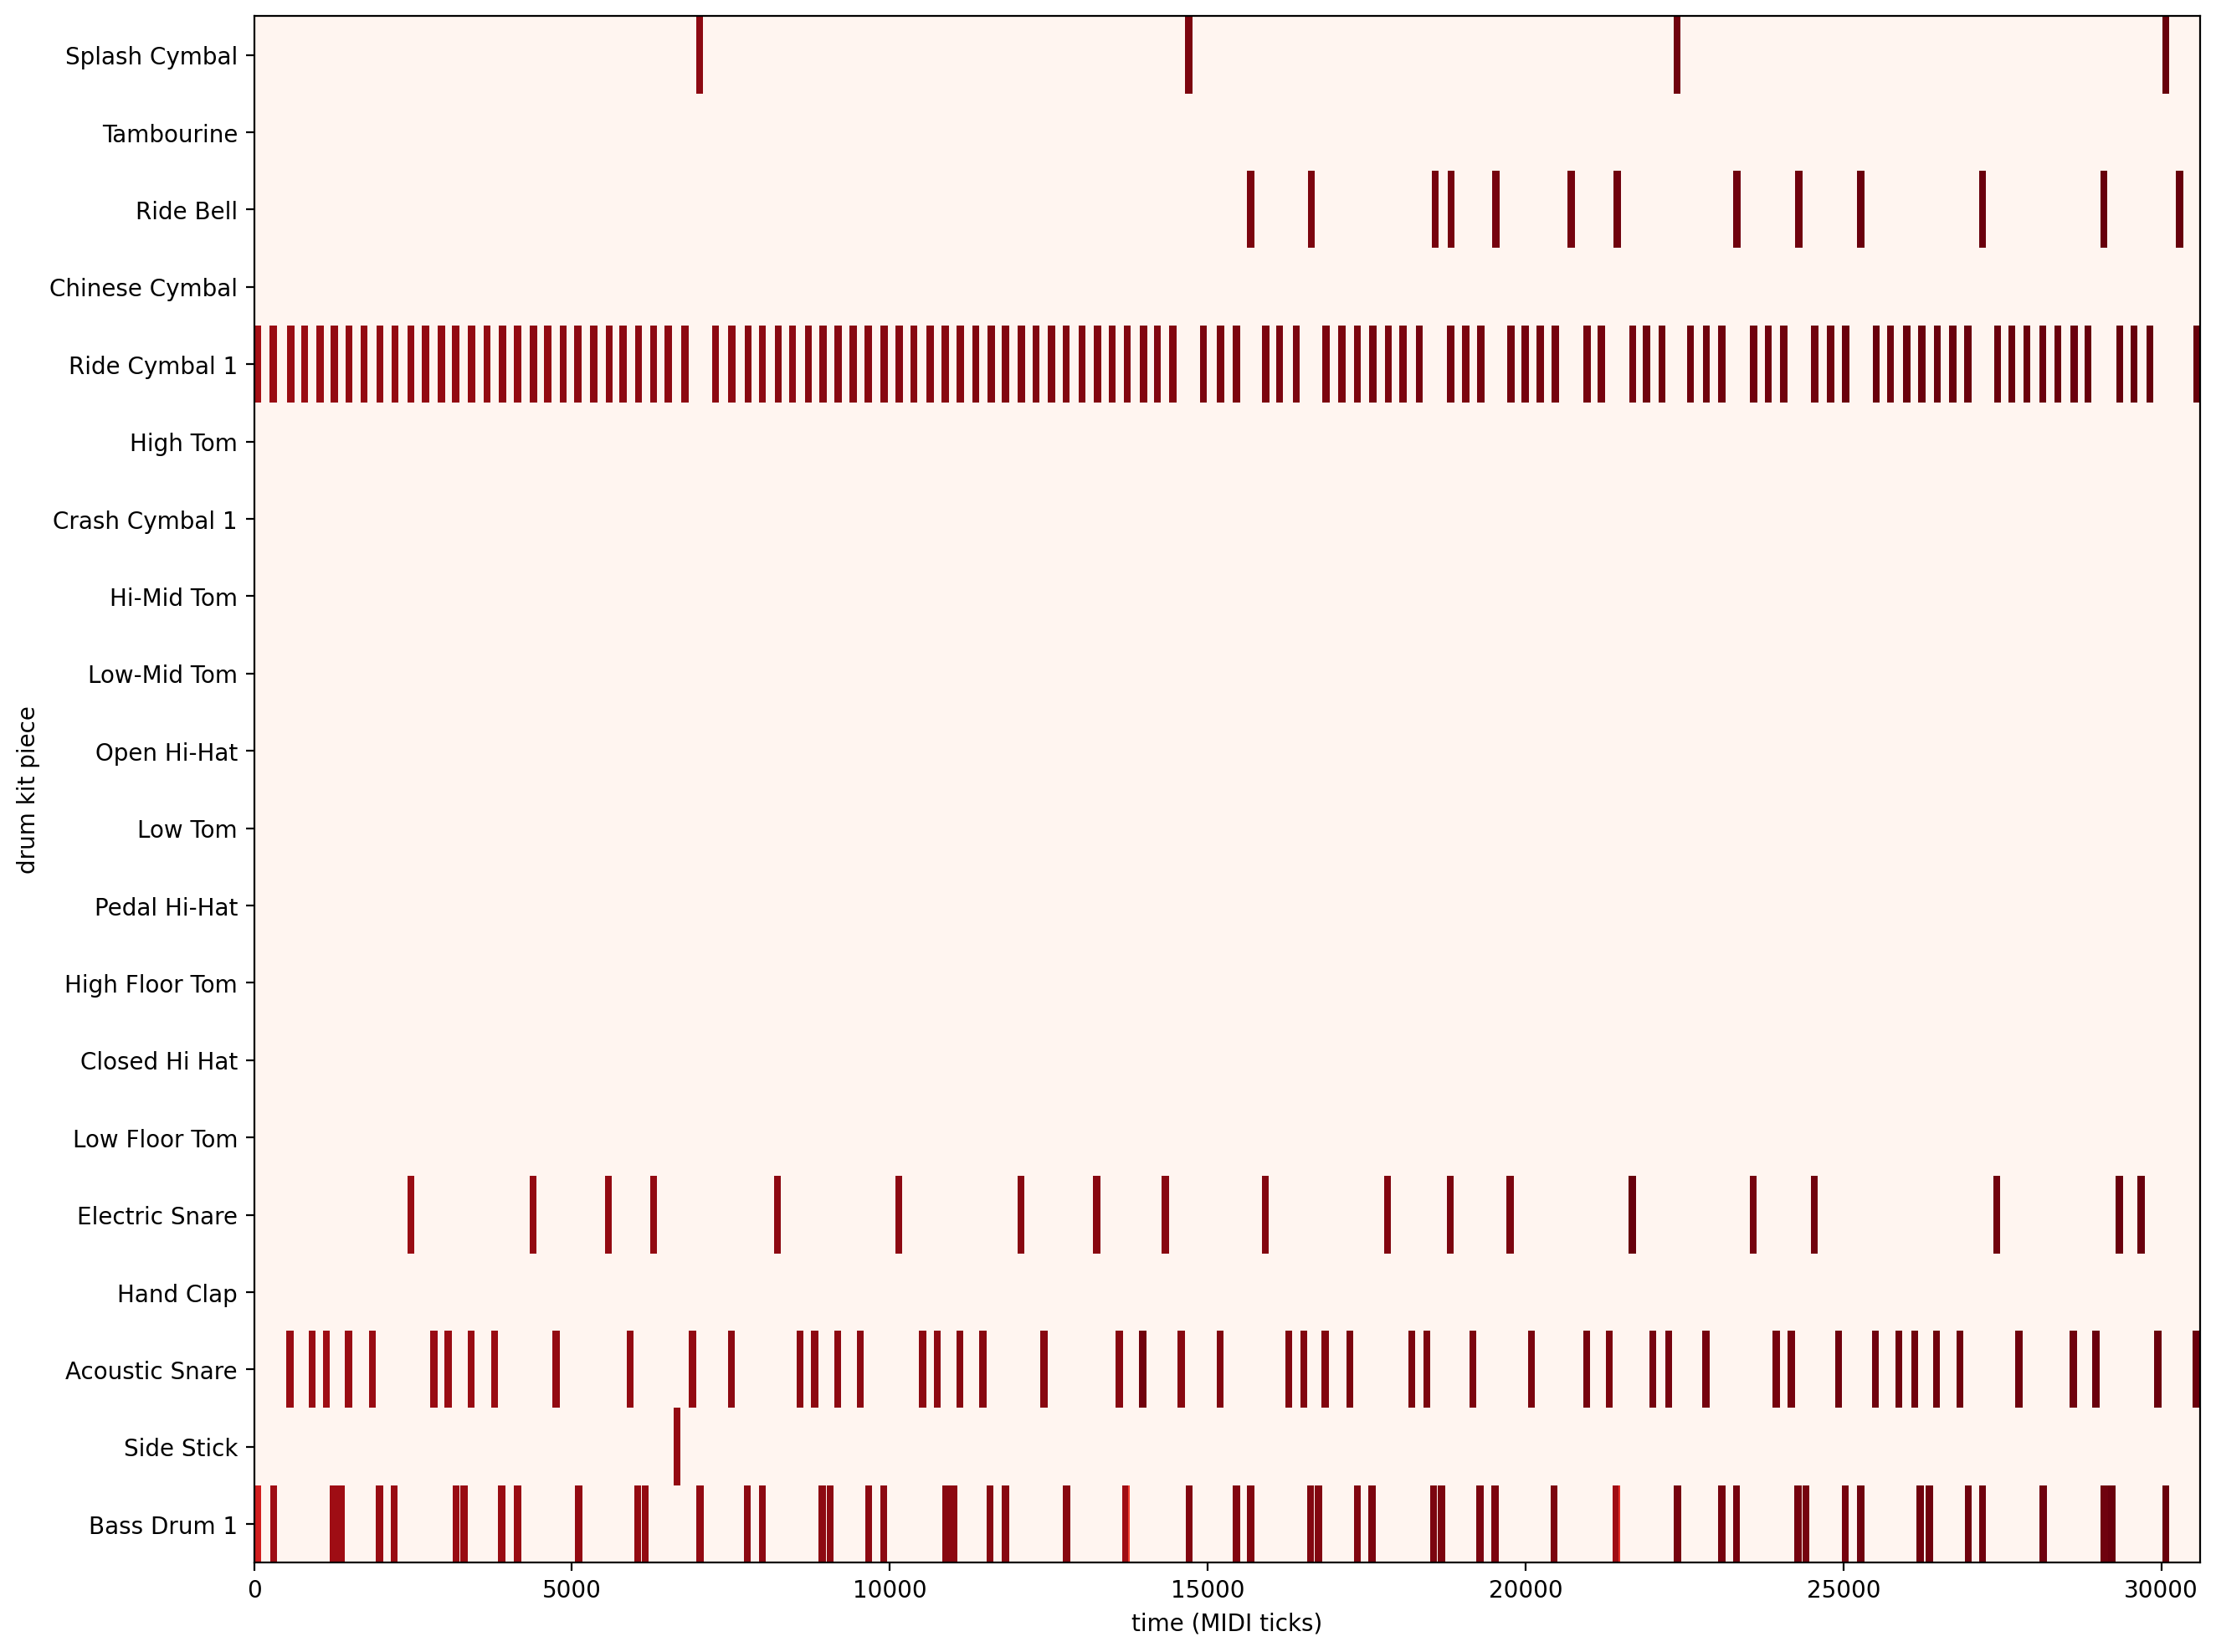

In [206]:
piano_roll(notes_pred, is_drums=True)

In [ ]:
play_midi_notes(notes_pred, is_drums=True)

For debug purposes, let's see the spread of generated velocities.

(array([ 1.,  1.,  1.,  0.,  0.,  0.,  1., 81., 80., 92.]),
 array([53. , 56.4, 59.8, 63.2, 66.6, 70. , 73.4, 76.8, 80.2, 83.6, 87. ]),
 <BarContainer object of 10 artists>)

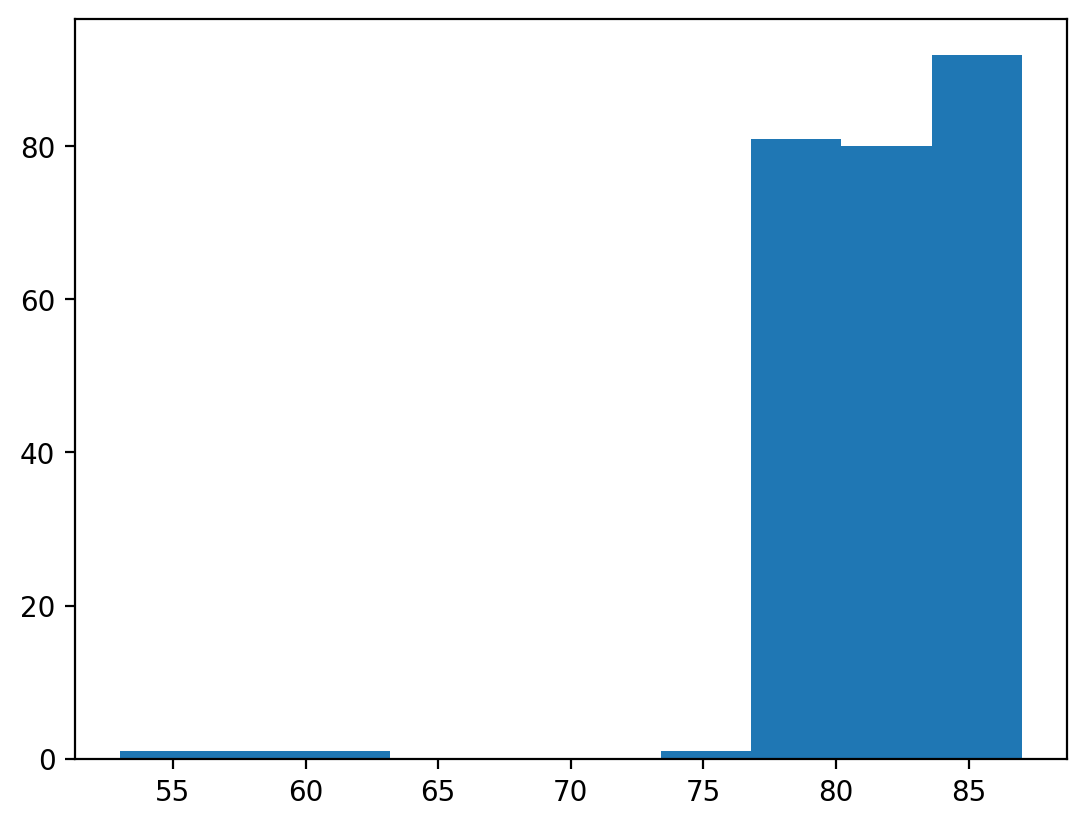

In [208]:
plt.hist(velocities_pred)

## Piano experiments

### Preparing piano data

In [241]:
piano_df = asap_metadata_df[["midi_performance"]]
piano_df.sample(10)

,midi_performance
430,Beethoven/Piano_Sonatas/7-1/Larionova04M.mid
541,Chopin/Etudes_op_10/12/Staupe02.mid
186,Beethoven/Piano_Sonatas/11-1/NAKAJI01.mid
218,Beethoven/Piano_Sonatas/17-1_no_repeat/Richardson02M.mid
76,Bach/Fugue/bwv_889/YangY02M.mid
291,Beethoven/Piano_Sonatas/23-1/KARYAG01.mid
488,Chopin/Ballades/4/ZhangX02.mid
658,Chopin/Etudes_op_25/11/Tan03.mid
1009,Schubert/Piano_Sonatas/664-1/Mo10M.mid
415,Beethoven/Piano_Sonatas/32-1/Park01.mid


In [242]:

def append_piano_midi_features(df: pd.DataFrame):
    features_df = pd.DataFrame(columns=['notes_array', 'velocities_array'])
    for i, (filename,) in enumerate(df.values):
        if i % 1000 == 0:
            print(f"{i//1000}K", end="")
        elif i % 100 == 0:
            print(".", end="")
        
        filepath = os.path.join(ASAP_BASE_PATH, filename)
        midi = partitura.load_performance_midi(filepath)
        notes = midi.performedparts[0].note_array()
        velocities = [t[Idx.VELOCITY.value] for t in notes]
        features_df.loc[len(features_df)] = [notes, velocities]
    df = pd.concat([df.reset_index(drop=True), features_df], axis=1)
    return df

In [243]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # ignoring warnings for MIDI msg with velocity=0
    piano_df = append_piano_midi_features(piano_df)

0K.........1K

In [245]:
piano_df.sample(3)

,midi_performance,notes_array,velocities_array
1007,Schubert/Piano_Sonatas/664-1/KabuliL10M.mid,"[[0.98229164, 0.93541664, 943, 361, 73, 48, 0, 0, n0], [1.4604167, 0.5072917, 1402, 487, 74, 54, 0, 0, n1], [1.646875, 1.43125, 1581, 889, 61, 37, 0, 0, n2], [1.7697917, 1.3083333, 1699, 933, 69, 41, 0, 0, n3], [1.8260417, 1.2520833, 1753, 801, 45, 31, 0, 0, n4], [1.9302083, 1.1479167, 1853, 817, 76, 65, 0, 0, n5], [2.2479167, 0.83020836, 2158, 369, 49, 47, 0, 0, n6], [2.471875, 0.66041666, 2373, 634, 52, 43, 0, 0, n7], [2.7479167, 0.33020833, 2638, 293, 57, 41, 0, 0, n8], [3.00625, 1.2177083, 2886, 1169, 47, 39, 0, 0, n9], [3.0677083, 1.0302083, 2945, 401, 74, 58, 0, 0, n10], [3.0958333, ...","[48, 54, 37, 41, 31, 65, 47, 43, 41, 39, 58, 42, 15, 34, 63, 65, 31, 39, 75, 44, 56, 41, 50, 49, 29, 37, 65, 39, 76, 41, 80, 40, 73, 40, 33, 48, 36, 44, 69, 44, 69, 37, 37, 39, 62, 33, 64, 68, 34, 34, 64, 41, 21, 31, 43, 45, 52, 52, 40, 74, 42, 73, 44, 78, 45, 54, 34, 38, 32, 39, 66, 38, 49, 36, 77, 76, 45, 47, 85, 50, 70, 42, 39, 39, 45, 41, 41, 30, 59, 38, 69, 76, 46, 47, 74, 51, 11, 45, 59, 32, ...]"
423,Beethoven/Piano_Sonatas/4-1/SirajA02M.mid,"[[0.98854166, 0.94895834, 949, 911, 67, 78, 0, 0, n0], [0.99895835, 0.36979166, 959, 105, 39, 58, 0, 0, n1], [1.0010417, 0.61875, 961, 594, 63, 70, 0, 0, n2], [1.0020833, 0.58125, 962, 558, 58, 66, 0, 0, n3], [1.1572917, 0.21145834, 1111, 60, 51, 59, 0, 0, n4], [1.3020834, 0.06666667, 1250, 42, 51, 64, 0, 0, n5], [1.4416667, 0.046875, 1384, 45, 51, 61, 0, 0, n6], [1.584375, 0.054166667, 1521, 52, 51, 64, 0, 0, n7], [1.7260417, 0.046875, 1657, 45, 51, 65, 0, 0, n8], [1.875, 0.37395832, 1800, 359, 58, 59, 0, 0, n9], [1.8791667, 0.054166667, 1804, 52, 51, 62, 0, 0, n10], [1.8875, 0.30208334, ...","[78, 58, 70, 66, 59, 64, 61, 64, 65, 59, 62, 51, 62, 66, 68, 67, 69, 70, 75, 87, 79, 80, 78, 56, 73, 65, 68, 64, 59, 63, 61, 63, 62, 72, 70, 71, 73, 78, 69, 34, 60, 26, 51, 70, 67, 66, 34, 52, 63, 67, 60, 38, 39, 60, 64, 69, 58, 54, 43, 45, 59, 34, 72, 75, 49, 49, 80, 80, 80, 37, 43, 78, 77, 75, 74, 69, 61, 36, 39, 62, 41, 69, 80, 83, 59, 44, 81, 86, 58, 88, 68, 84, 87, 86, 79, 67, 56, 61, 84, 76, ...]"
672,Chopin/Etudes_op_25/4/Taverna02.mid,"[[1.5090797, 0.5341875, 1130, 175, 52, 62, 0, 0, n0], [1.985842, 0.12686953, 1487, 95, 45, 69, 0, 0, n1], [2.1848269, 0.05475422, 1636, 41, 76, 68, 0, 0, n2], [2.204859, 0.03071578, 1651, 23, 64, 51, 0, 0, n3], [2.2075298, 0.03205125, 1653, 24, 69, 47, 0, 0, n4], [2.2102008, 0.03338672, 1655, 25, 60, 57, 0, 0, n5], [2.2195492, 0.040064063, 1662, 30, 52, 45, 0, 0, n6], [2.370457, 0.049412344, 1775, 37, 48, 67, 0, 0, n7], [2.5467389, 0.07345078, 1907, 55, 81, 73, 0, 0, n8], [2.5507452, 0.05475422, 1910, 41, 69, 69, 0, 0, n9], [2.5574226, 0.049412344, 1915, 37, 76, 67, 0, 0, n10], [2.561429, ...","[62, 69, 68, 51, 47, 57, 45, 67, 73, 69, 67, 55, 35, 59, 76, 67, 66, 65, 66, 64, 66, 63, 65, 56, 64, 69, 80, 71, 66, 72, 69, 86, 70, 68, 75, 66, 68, 82, 71, 69, 64, 66, 67, 68, 70, 57, 57, 60, 68, 80, 76, 75, 72, 50, 71, 88, 63, 74, 77, 72, 76, 82, 89, 77, 81, 75, 79, 82, 74, 66, 68, 60, 72, 76, 62, 59, 59, 61, 63, 79, 74, 67, 66, 47, 17, 64, 79, 88, 83, 52, 49, 57, 89, 70, 79, 64, 75, 69, 64, 83, ...]"


In [246]:
def extract_piano_tensor_features(df_row: pd.Series) -> tuple[torch.Tensor]:
    """Return a tensor containing features to feed the NN with. Data is normalized [0-1]."""
    max_secs = max(t[Idx.ONSET_SECS.value] + t[Idx.DURATION_SECS.value] for t in df_row['notes_array'])
    max_duration = max(t[Idx.DURATION_SECS.value] for t in df_row['notes_array'])

    features = torch.Tensor([
        [
            t[Idx.ONSET_SECS.value] / max_secs,  # TODO: use dt instead of absolute time?
            t[Idx.DURATION_SECS.value] / max_duration,
            t[Idx.PITCH.value] / 127, 
            # TODO: add more features, temporal-based, melodic/harmonic value, etc
        ]
        for t in df_row['notes_array']
    ])
    
    return features

(array([348., 334., 227.,  94.,  40.,  14.,   0.,   0.,   0.,  10.]),
 array([  414.        ,  2080.60009766,  3747.19995117,  5413.79980469,
         7080.39990234,  8747.        , 10413.59960938, 12080.20019531,
        13746.79980469, 15413.40039062, 17080.        ]),
 <BarContainer object of 10 artists>)

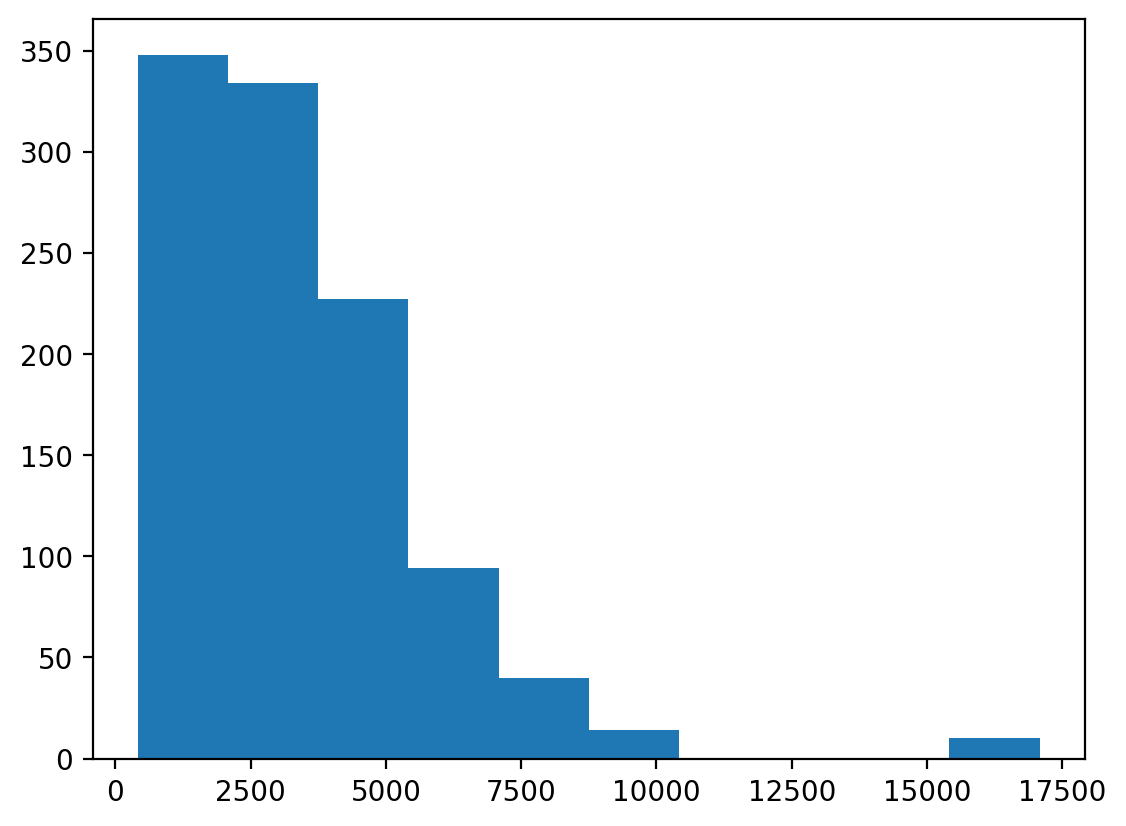

In [254]:
piano_lengths = torch.Tensor(sequence_lengths(piano_df))

plt.hist(piano_lengths)

In [251]:
def get_piano_X_y(df: pd.DataFrame) -> tuple[torch.Tensor, torch.Tensor]:
    X = [
        extract_piano_tensor_features(row)
        for _, row in df.iterrows()
    ]
    y = [
        torch.Tensor(row['velocities_array']) / 127
        for _, row in df.iterrows()
    ]

    X = nn.utils.rnn.pad_sequence(X, batch_first=True)
    y = nn.utils.rnn.pad_sequence(y, batch_first=True)[..., None]

    return X, y


In [252]:
X_piano, y_piano = get_piano_X_y(piano_df)
X_piano.shape, y_piano.shape

(torch.Size([1067, 17080, 3]), torch.Size([1067, 17080, 1]))

In [279]:

X_piano_train, X_piano_valid, piano_train_lengths, piano_valid_lengths, y_piano_train, y_piano_valid = train_test_split(
    X_piano, piano_lengths, y_piano, test_size=0.2, random_state=42
)

piano_train_lengths = piano_train_lengths.to(torch.int)
piano_valid_lengths = piano_valid_lengths.to(torch.int)

X_piano_train.shape, X_piano_valid.shape, piano_train_lengths.shape, piano_valid_lengths.shape, y_piano_train.shape, y_piano_valid.shape

(torch.Size([853, 17080, 3]),
 torch.Size([214, 17080, 3]),
 torch.Size([853]),
 torch.Size([214]),
 torch.Size([853, 17080, 1]),
 torch.Size([214, 17080, 1]))

In [272]:
piano_train_ds = TensorDataset(X_piano_train, piano_train_lengths, y_piano_train)
piano_valid_ds = TensorDataset(X_piano_valid, piano_valid_lengths, y_piano_valid)

In [273]:
piano_train_dataloader = DataLoader(piano_train_ds, batch_size=64)
piano_valid_dataloader = DataLoader(piano_valid_ds, batch_size=64)

### Learning how to play the piano

In [274]:
class PianoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # TODO: linear layer?

    def forward(self, x, seq_lengths):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(packed_x)  # TODO: what to do with hidden state?
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        return x

In [275]:
piano_model = PianoLSTM(input_size=X_piano_train.shape[-1], hidden_size=1, num_layers=1)  # TODO: try with more layers

In [277]:
NUM_EPOCHS = 10  # TODO: try with 3000 epochs
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(piano_model.parameters(), lr=0.01)  # TODO: try smaller lr (e.g. 3e-3)

def compute_loss(y_pred, y_true, seq_lengths):
    losses = [
        criterion(
            y_pred[batch_row, :seq_len, :], 
            y_true[batch_row, :seq_len, :]
        )
        for batch_row, seq_len in enumerate(seq_lengths)
    ]
    return torch.mean(torch.stack(losses))


for epoch in range(NUM_EPOCHS):
    print(f"=== Epoch {epoch+1} / {NUM_EPOCHS} ===")

    piano_model.train()  # training
    for i, (X, seq_lengths, y) in enumerate(piano_train_dataloader):
        y_pred = piano_model(X, seq_lengths)

        loss = compute_loss(y_pred, y, seq_lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 3 == 0:
            print(f"[T] Batch {i} / {len(piano_train_dataloader)-1} loss: {loss.item():.4f}")

    piano_model.eval()  # validation
    with torch.no_grad():
        validation_losses = []
        for i, (X, seq_lengths, y) in enumerate(piano_valid_dataloader):
            y_pred = piano_model(X, seq_lengths)
            validation_losses.append(compute_loss(y_pred, y, seq_lengths))
        print(f"[V] Validation mean loss: {torch.mean(torch.stack(validation_losses)).item():.4f}")
    

=== Epoch 1 / 10 ===
[T] Batch 0 / 13 loss: 0.0257
[T] Batch 3 / 13 loss: 0.0235
[T] Batch 6 / 13 loss: 0.0216
[T] Batch 9 / 13 loss: 0.0235
[T] Batch 12 / 13 loss: 0.0207
[V] Validation mean loss: 0.0214
=== Epoch 2 / 10 ===
[T] Batch 0 / 13 loss: 0.0208
[T] Batch 3 / 13 loss: 0.0198
[T] Batch 6 / 13 loss: 0.0190
[T] Batch 9 / 13 loss: 0.0217
[T] Batch 12 / 13 loss: 0.0189
[V] Validation mean loss: 0.0199
=== Epoch 3 / 10 ===
[T] Batch 0 / 13 loss: 0.0193
[T] Batch 3 / 13 loss: 0.0187
[T] Batch 6 / 13 loss: 0.0182
[T] Batch 9 / 13 loss: 0.0214
[T] Batch 12 / 13 loss: 0.0185
[V] Validation mean loss: 0.0195
=== Epoch 4 / 10 ===
[T] Batch 0 / 13 loss: 0.0188
[T] Batch 3 / 13 loss: 0.0185
[T] Batch 6 / 13 loss: 0.0179
[T] Batch 9 / 13 loss: 0.0211
[T] Batch 12 / 13 loss: 0.0184
[V] Validation mean loss: 0.0193
=== Epoch 5 / 10 ===
[T] Batch 0 / 13 loss: 0.0186
[T] Batch 3 / 13 loss: 0.0184
[T] Batch 6 / 13 loss: 0.0178
[T] Batch 9 / 13 loss: 0.0208
[T] Batch 12 / 13 loss: 0.0183
[V] Vali

In [280]:
compute_loss(piano_model(X_piano_valid, piano_valid_lengths), y_piano_valid, piano_valid_lengths).item()

0.018521122634410858

In [282]:
# Baseline loss
baseline_velocity = torch.Tensor([100 / 127])  # velocity of 100 seems pretty average
y_baseline = baseline_velocity.repeat(*y_piano_valid.shape)

compute_loss(y_baseline, y_piano_valid, piano_valid_lengths).item()

0.10053467750549316

### Let's hear it play!

Get a random sample

In [303]:
piano_sample = piano_df.sample(1)
piano_sample_file_notes = piano_sample.iloc[0]["notes_array"]

Inspect and hear the original

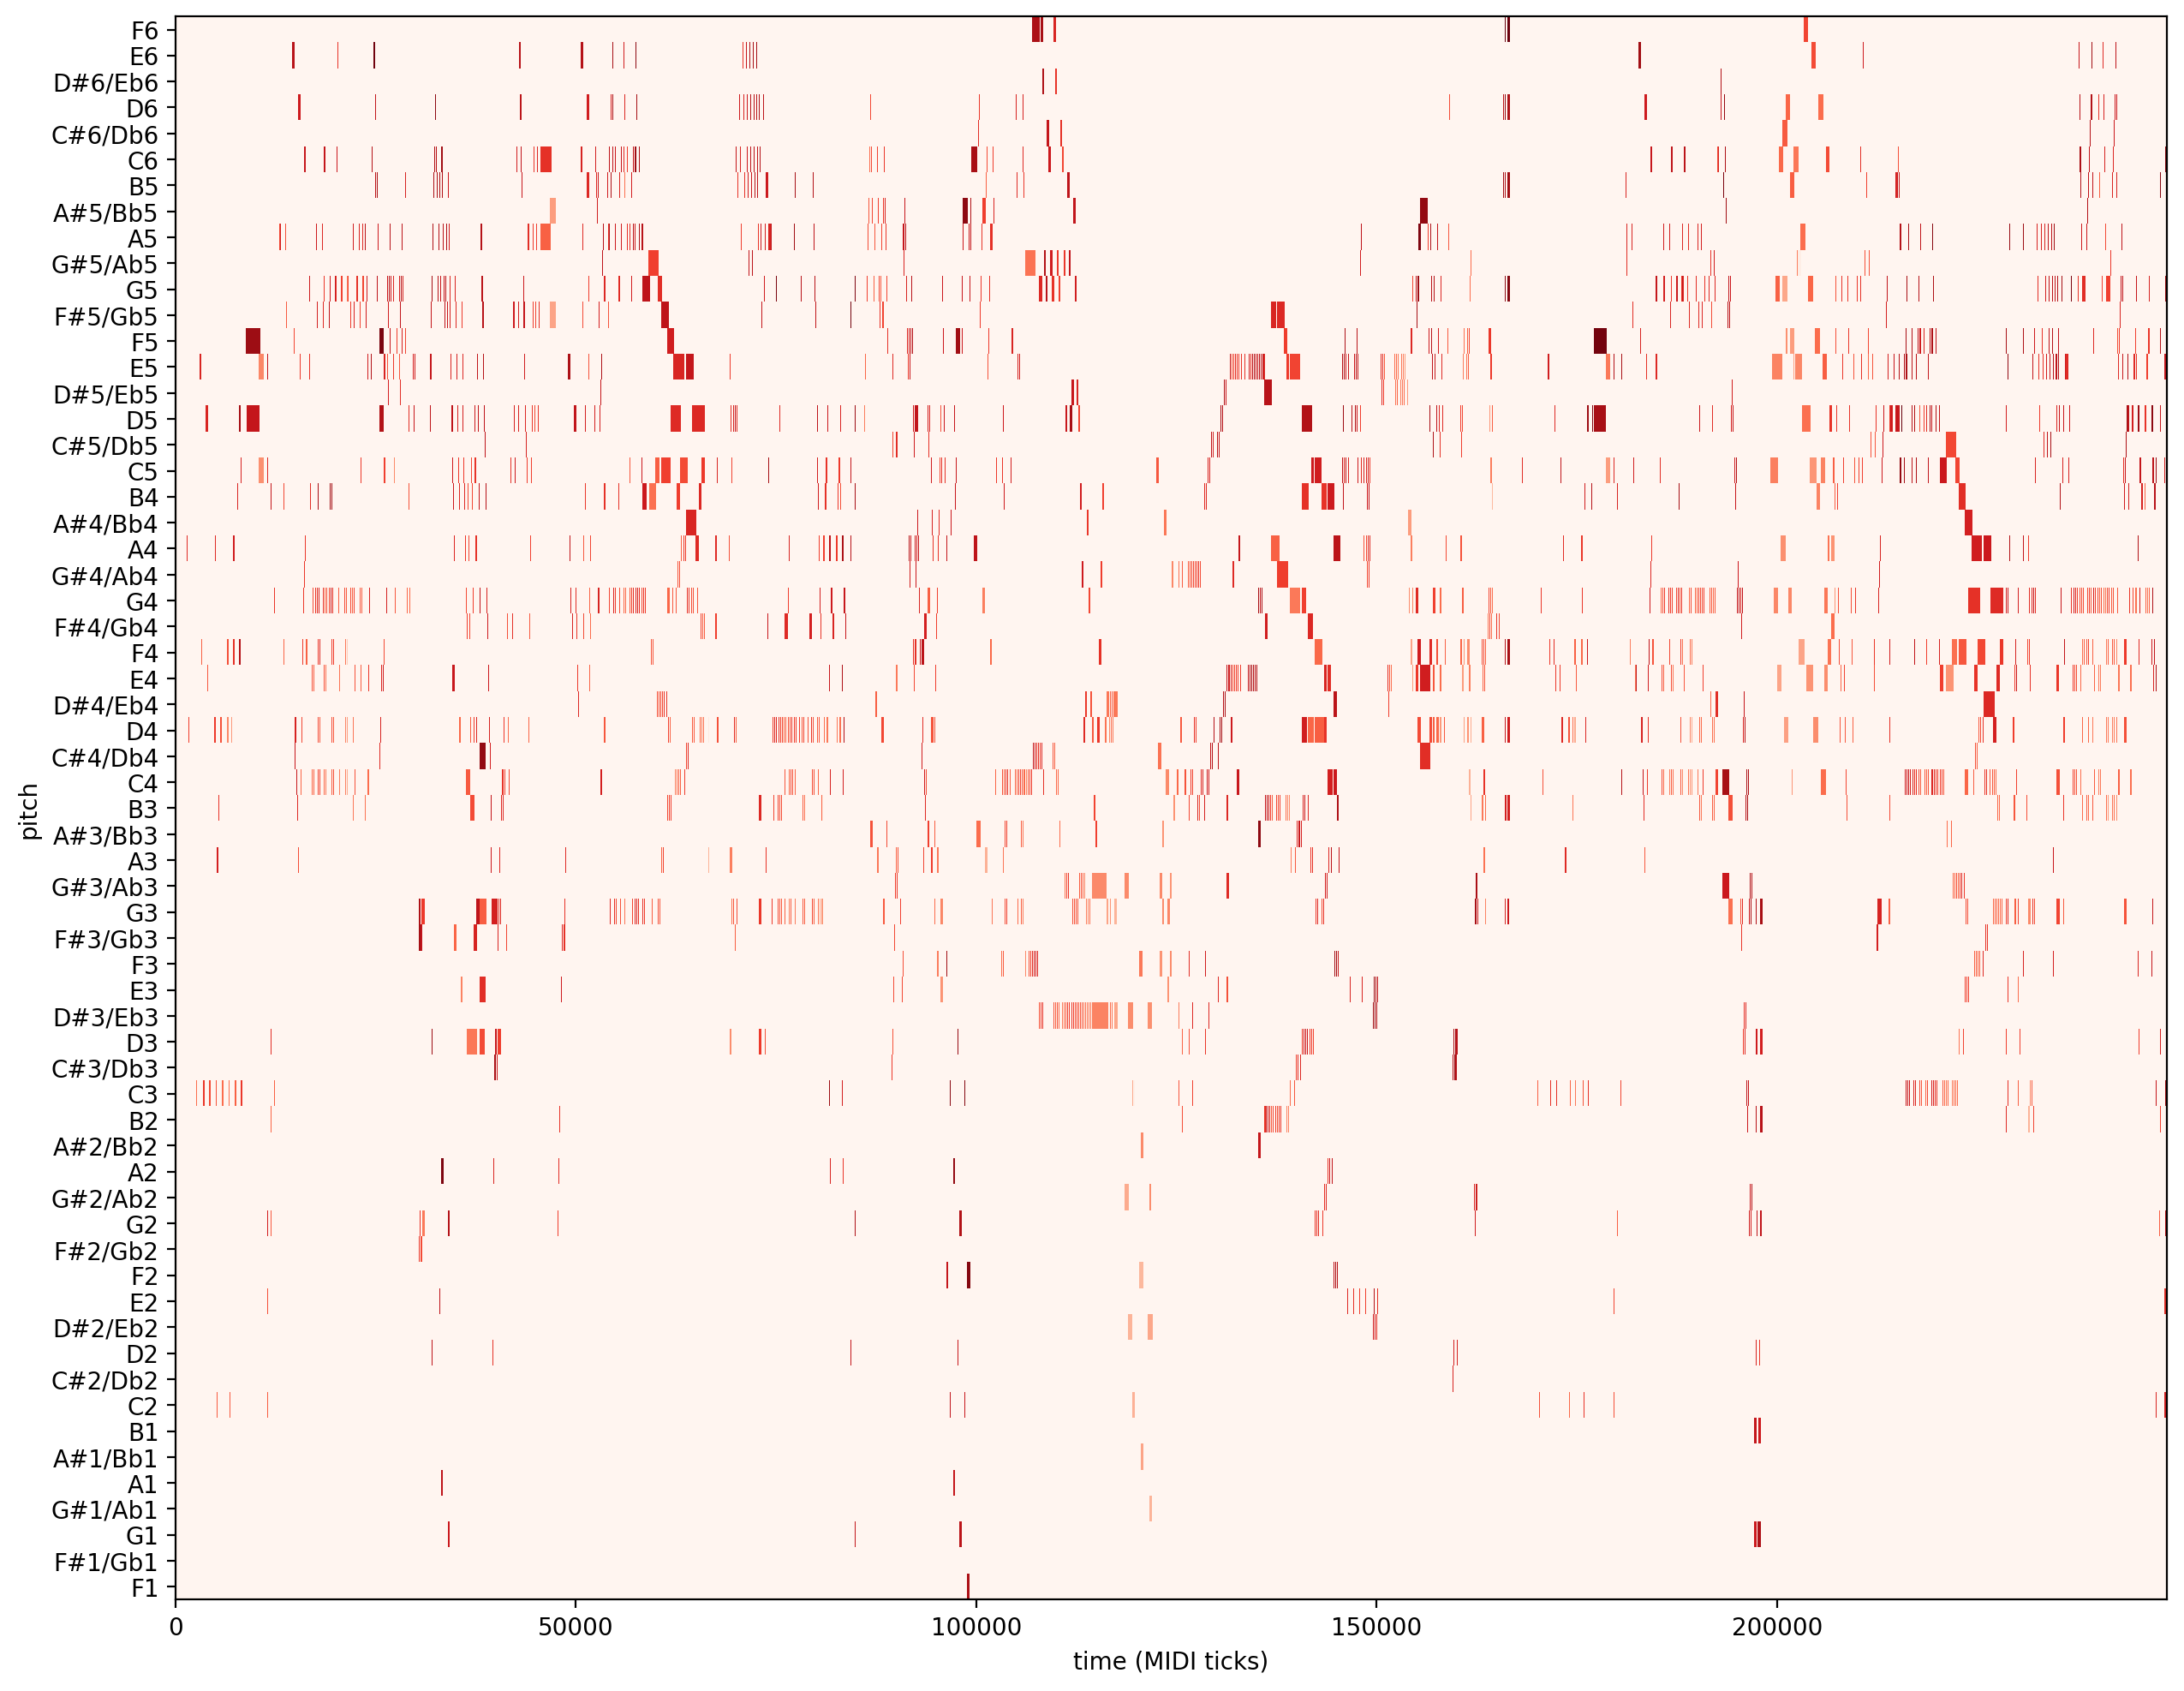

In [305]:
piano_roll(piano_sample_file_notes)

In [ ]:
play_midi_notes(piano_sample_file_notes)

(array([  4.,   1.,  30., 114., 437., 869., 847., 809., 328.,  57.]),
 array([  3. ,  12.7,  22.4,  32.1,  41.8,  51.5,  61.2,  70.9,  80.6,
         90.3, 100. ]),
 <BarContainer object of 10 artists>)

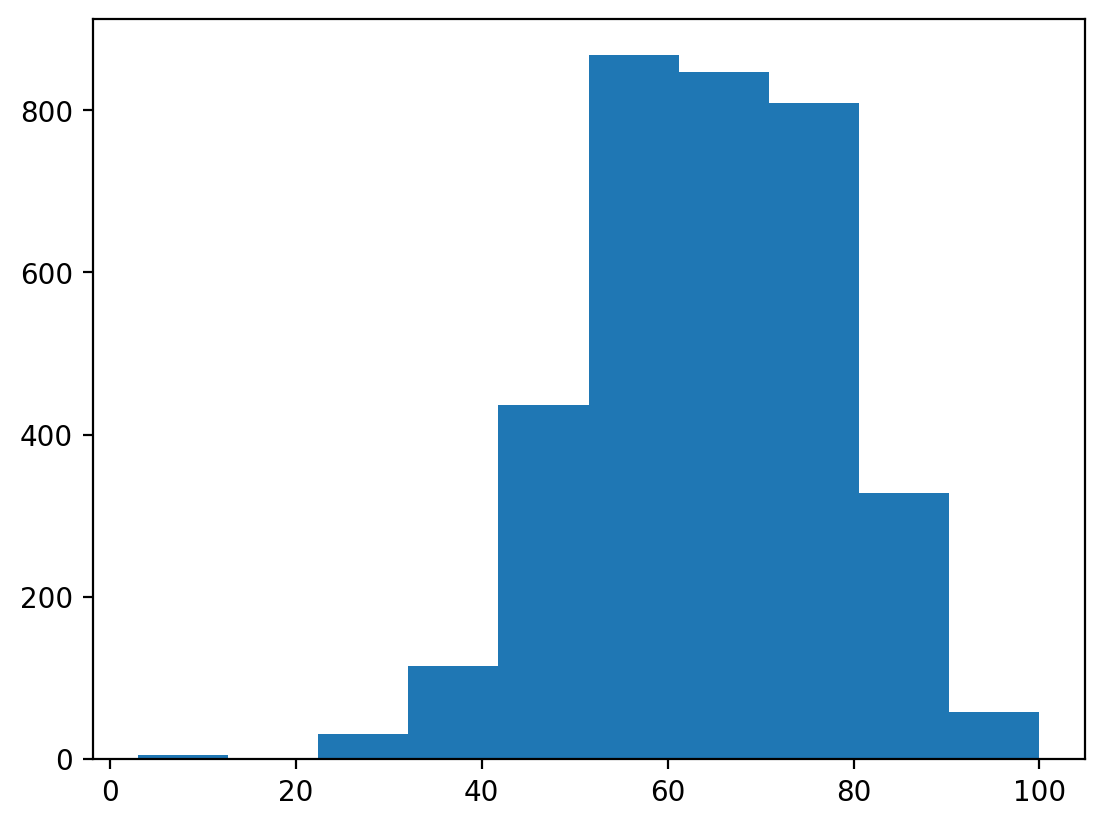

In [313]:
plt.hist([MidiNote(n).velocity for n in piano_sample_file_notes])

Run the model for the sample

In [307]:
X, y = get_piano_X_y(piano_sample)
seq_len = torch.LongTensor([len(piano_sample_file_notes)])

X.shape, y.shape, seq_len

(torch.Size([1, 3496, 3]), torch.Size([1, 3496, 1]), tensor([3496]))

Compute the loss for debugging purposes

In [308]:
y_pred = piano_model(X, seq_len)
velocities_pred = (y_pred[0, :seq_len[0], :].detach().numpy() * 127).astype(int)
notes_pred = piano_sample_file_notes.copy()
for i, velocity in enumerate(velocities_pred):
    notes_pred[i][Idx.VELOCITY.value] = velocity

mean_squared_error(
    [n[Idx.VELOCITY.value] for n in piano_sample_file_notes], 
    [n[Idx.VELOCITY.value] for n in notes_pred],
    squared=False
)

/var/folders/c1/wnpj64n160b5_hpc84y3ry340000gq/T/ipykernel_32445/4080277464.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  notes_pred[i][Idx.VELOCITY.value] = velocity


12.629738614984774

Inspect and hear the model's output

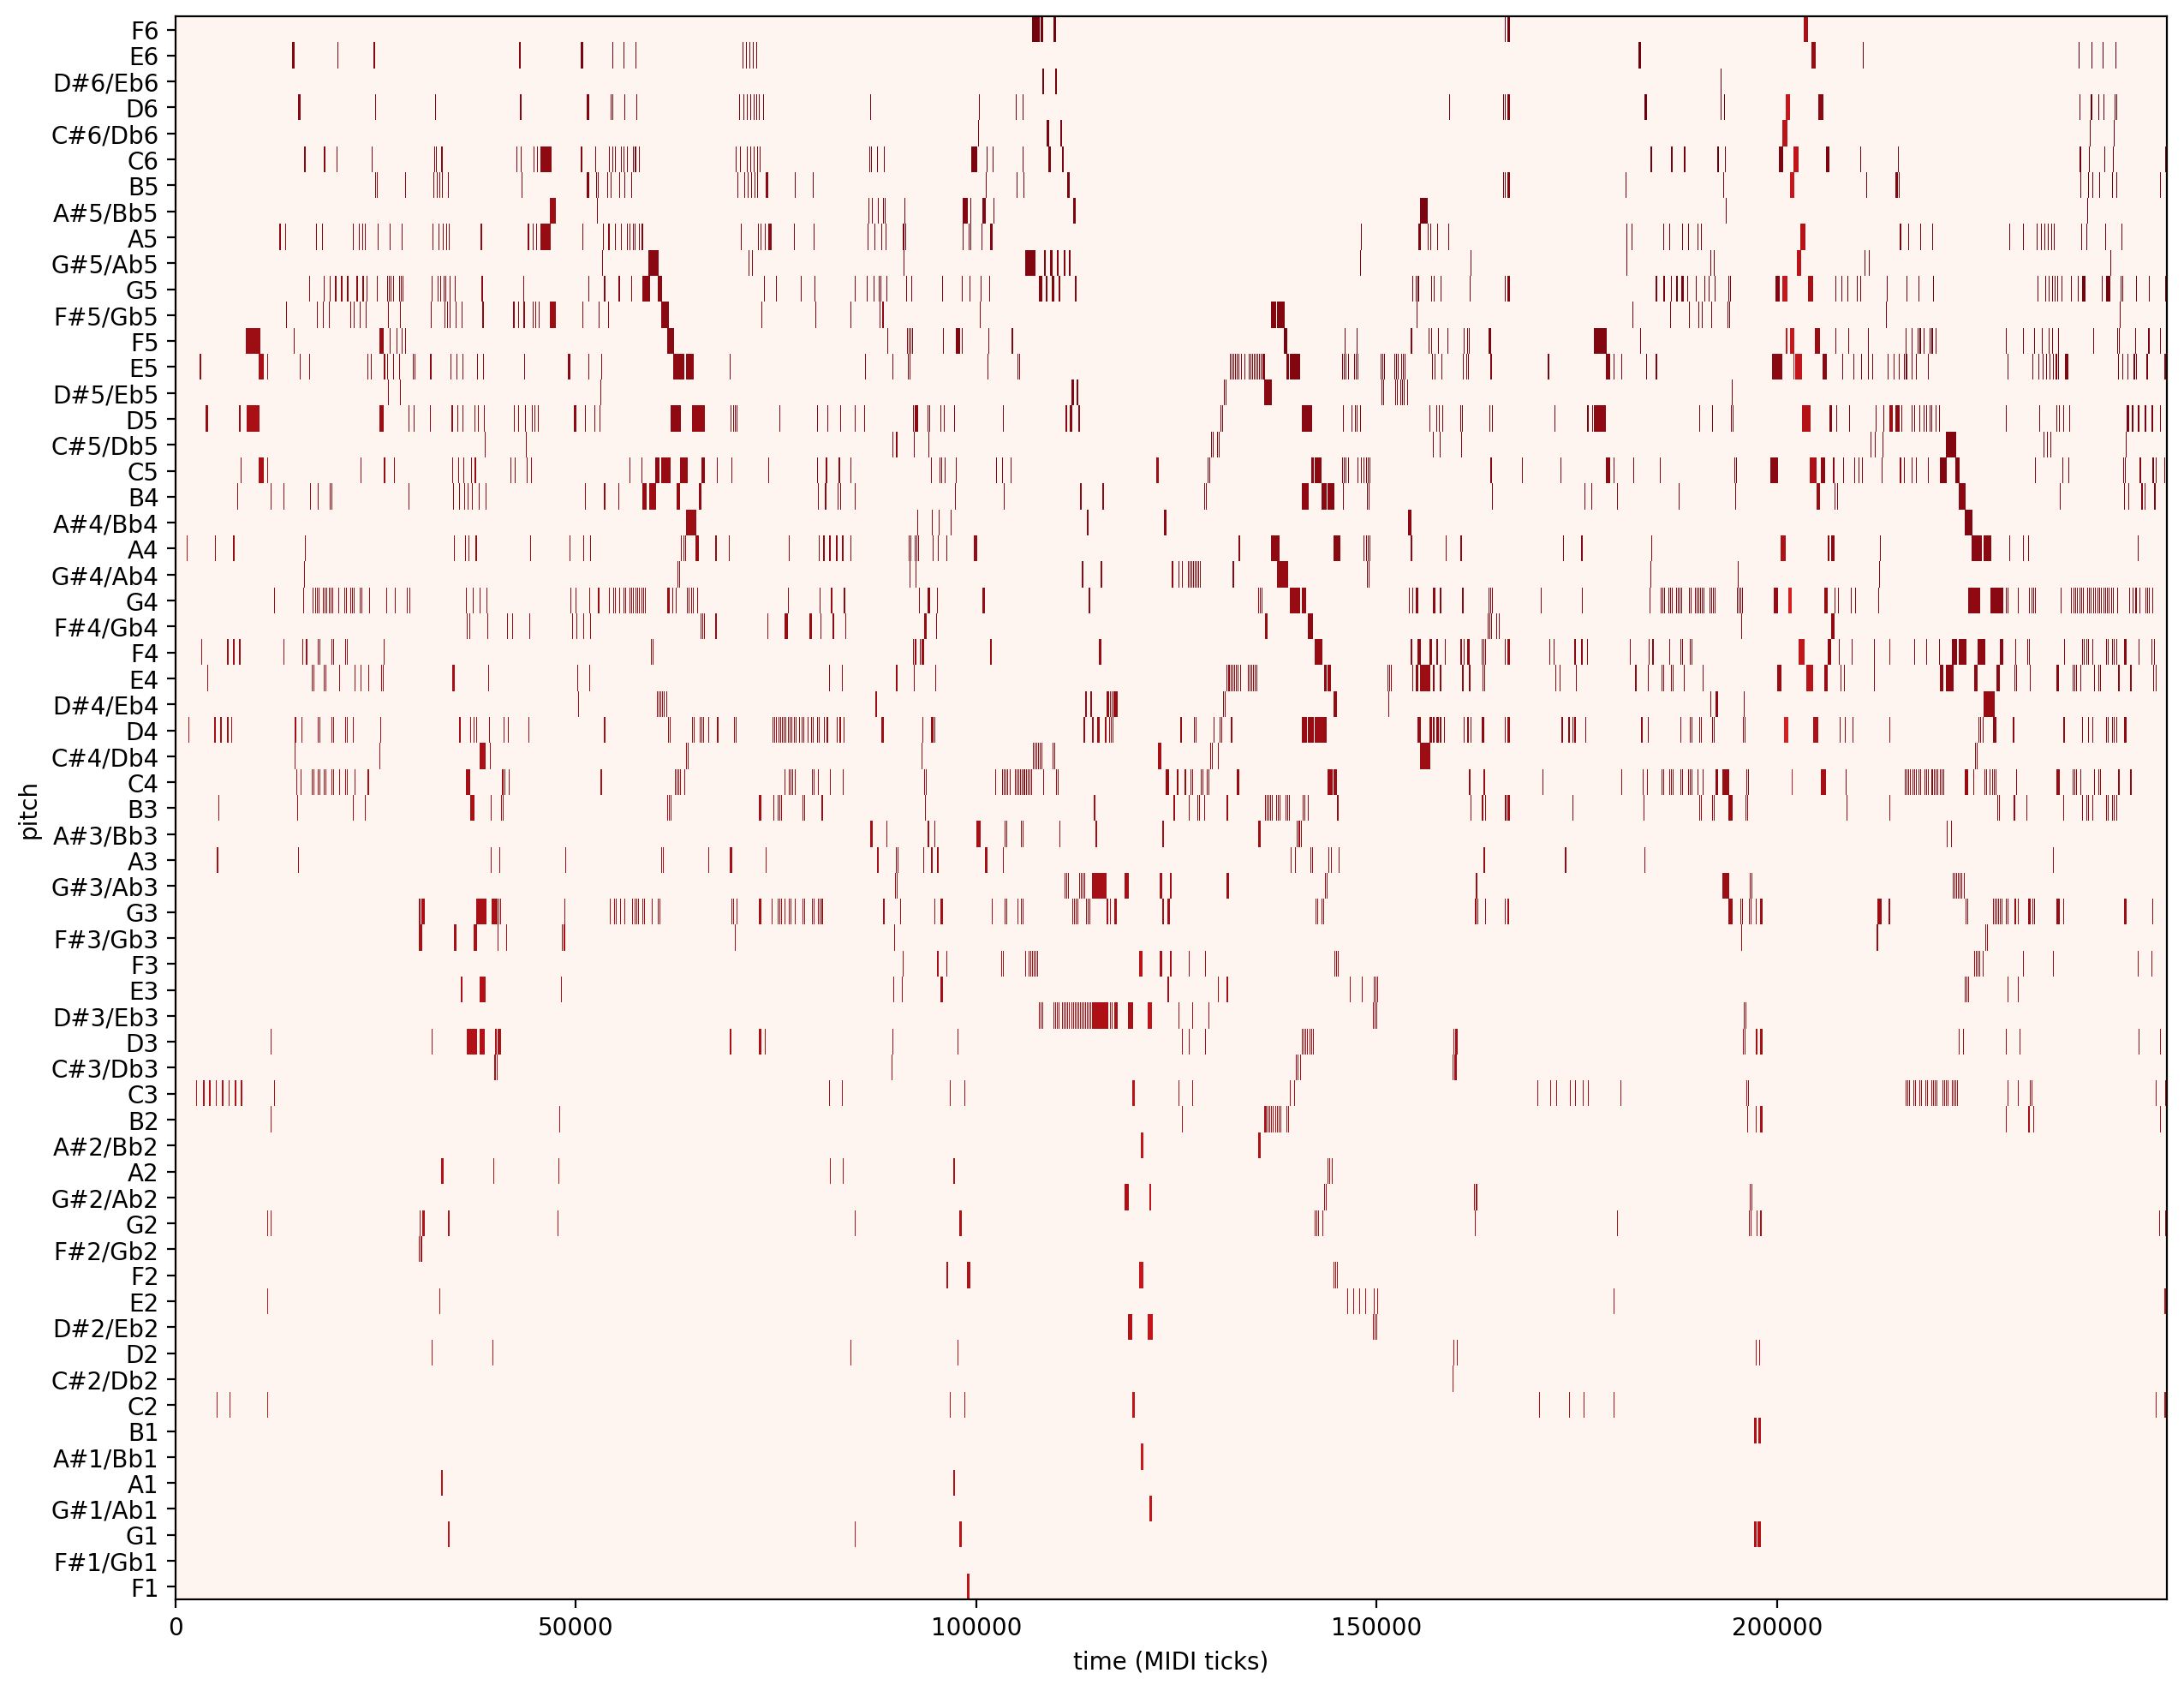

In [309]:
piano_roll(notes_pred)

In [ ]:
play_midi_notes(notes_pred)

For debug purposes, let's see the spread of generated velocities.

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 4.000e+00,
        2.600e+01, 3.260e+02, 2.256e+03, 8.810e+02]),
 array([23. , 27.8, 32.6, 37.4, 42.2, 47. , 51.8, 56.6, 61.4, 66.2, 71. ]),
 <BarContainer object of 10 artists>)

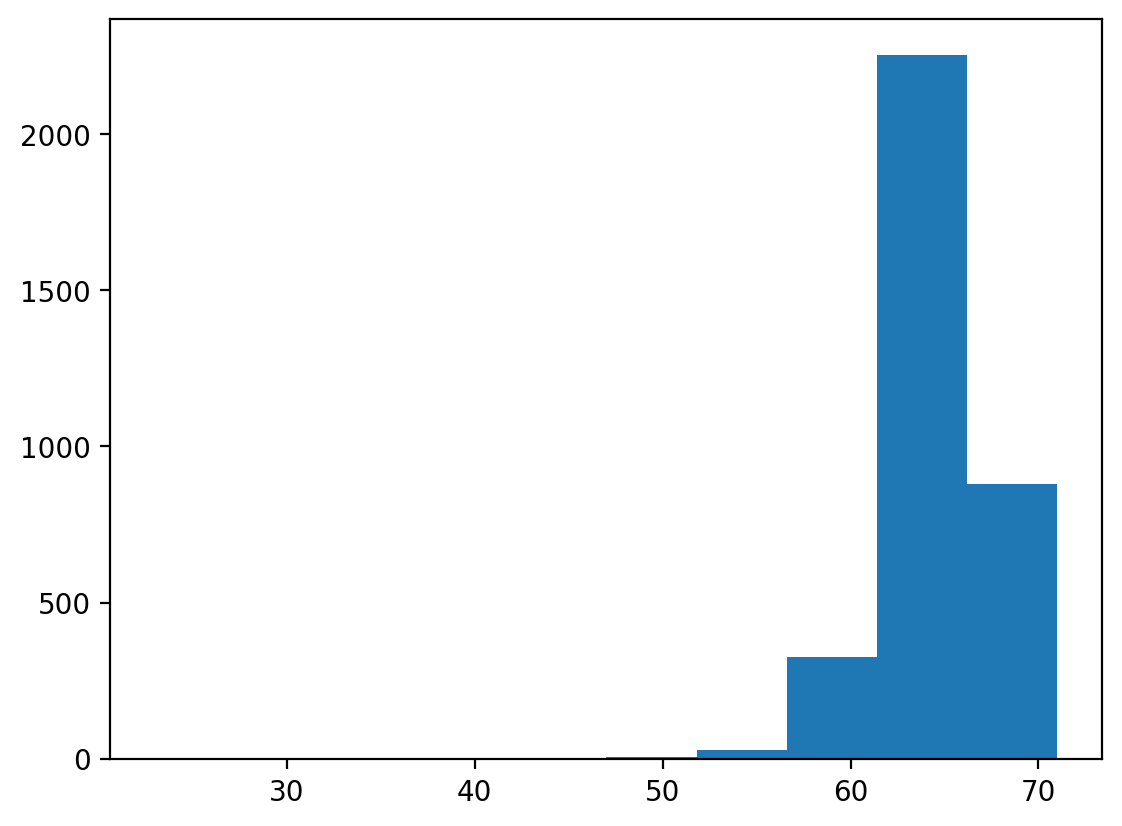

In [311]:
plt.hist(velocities_pred)